# **Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# **Logbook**

## Methods

Let's ensure we all use the same names for all components.

| **Variable**                 | **Name**                                      |
|------------------------------|-----------------------------------------------|
| Raw ECG dataframe            | df                                            |
| Label dataframe              | df_labels                                     |
| HRV features (train)         | hrv_train                                     |
| HRV features (test)          | hrv_test                                      |
| HRV extraction type          | FULL (nk.hrv — time + freq + nonlinear + RSA) |
| Clean HRV dataframe (train)  | hrv_train_clean                               |
| Clean HRV dataframe (test)   | hrv_test_clean                                |
| HRV + labels (train)         | hrv_train_with_labels                         |
| Winsorized HRV column        | HRV_MedianNN_winsor                           |
| Model feature matrix (train) | X_train                                       |
| Model feature matrix (test)  | X_test                                        |
| Model target vector (train)  | y_train                                       |
| Model target vector (test)   | y_test                                        |


| **Function**              | **Description**                                | **Arguments**                                |
|---------------------------|------------------------------------------------|----------------------------------------------|
| corr_plot_hrv()           | Correlation plot for HRV features              | df, cols=None                                |
| distplots_hrv()           | Distribution plots (hist + KDE)                | df, cols=None                                |
| boxplots_hrv()            | Boxplots for selected HRV variables            | df, cols                                     |
| check_missing_hrv()       | Missingness summary                            | df                                           |
| identify_outliers()       | IQR-based outlier detection                    | df, column_name, threshold=1.5               |
| model_evaluation()        | Confusion matrix + classification report       | model                                        |
| model_desc()              | Accuracy, CV, ROC-AUC, model performance       | model                                        |


# Preface

## Packages imports

In [119]:
try:
    print("Loading required packages...")
    import sys
    import random
    import os.path
    import warnings
    from tqdm import tqdm

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import neurokit2 as nk
    from scipy import stats
    import scipy.signal as signal
    from scipy.signal import welch
    import matplotlib.pyplot as plt
    from joblib.testing import xfail
    import plotly.graph_objects as go
    from colorama import Fore, Back, Style
    from plotly.subplots import make_subplots

    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.compose import make_column_transformer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
        f1_score, precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve
    from sympy import false

    print("Loading successful!")
except Exception:
    print("Installing required packages...")
    !pip install -r requirements.txt

Loading required packages...
Loading successful!


## Options settings

In [120]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
random.seed(3003)
IN_COLAB = 'google.colab' in sys.modules
DATA_PRESENT = os.path.isfile("data/Physionet2017Training.tar.xz")

## Dataset download

In [121]:
dataset_location = 'data/Physionet2017TrainingData.csv'

In [122]:
if not DATA_PRESENT:
    !mkdir data
    !wget https://github.com/MAI3003-Data-Witches/Data-Witches_Project2/raw/refs/heads/main/data/Physionet2017Training.tar.xz -O data/Physionet2017Training.tar.xz
    !tar -xf data/Physionet2017Training.tar.xz -C data
else:
    print(f"You already have the dataset downloaded at {dataset_location}, skipping")

You already have the dataset downloaded at data/Physionet2017TrainingData.csv, skipping


In [123]:
df = pd.read_csv(dataset_location, header=None, index_col=False) * 1000  # Load the dataset already in mV

df.head()

0       1       2       3       4       5       6       7       8     \
0 -126000 -141000 -152000 -159000 -160000 -153000 -140000 -126000 -111000   
1   23000   25000   33000   61000   79000   85000   89000   93000   96000   
2 -116000 -146000 -174000 -190000 -199000 -207000 -211000 -211000 -207000   
3 -500000 -597000 -695000 -792000 -873000 -917000 -918000 -873000 -822000   
4  -74000  -96000 -118000 -141000 -153000 -162000 -169000 -174000 -177000   

     9       10      11      12      13      14      15      16      17    \
0  -93000  -72000  -46000  -17000       0   22000   55000   94000  123000   
1   98000   98000   99000  100000  100000  101000  101000  102000  102000   
2 -201000 -194000 -190000 -187000 -184000 -180000 -176000 -172000 -169000   
3 -767000 -751000 -740000 -730000 -722000 -715000 -709000 -703000 -698000   
4 -179000 -180000 -180000 -179000 -175000 -171000 -165000 -159000 -152000   

     18      19      20      21      22      23      24      25      26    \
0  145000  163000  169000  171000  171000  172000  172000  173000  174000   
1  102000  101000  102000  102000  103000  103000  103000  104000  106000   
2 -168000 -167000 -167000 -167000 -167000 -169000 -170000 -173000 -175000   
3 -695000 -693000 -691000 -690000 -689000 -687000 -685000 -683000 -682000   
4 -142000 -123000 -104000  -96000  -92000  -89000  -86000  -84000  -82000   

     27      28      29      30      31      32      33      34      35    \
0  173000  172000  172000  172000  171000  170000  169000  169000  170000   
1  108000  110000  111000  113000  115000  117000  118000  120000  121000   
2 -177000 -178000 -180000 -182000 -184000 -186000 -188000 -190000 -192000   
3 -681000 -680000 -680000 -681000 -684000 -688000 -695000 -701000 -706000   
4  -81000  -80000  -80000  -79000  -77000  -75000  -75000  -74000  -73000   

     36      37      38      39      40      41      42      43      44    \
0  169000  169000  171000  173000  176000  178000  181000  185000  191000   
1  124000  127000  131000  135000  139000  144000  147000  151000  155000   
2 -194000 -196000 -197000 -199000 -199000 -199000 -198000 -197000 -194000   
3 -713000 -720000 -727000 -733000 -737000 -740000 -743000 -747000 -753000   
4  -73000  -72000  -71000  -70000  -70000  -69000  -69000  -68000  -67000   

     45      46      47      48      49      50      51      52      53    \
0  203000  214000  227000  249000  277000  296000  312000  335000  367000   
1  160000  166000  173000  186000  199000  213000  229000  248000  267000   
2 -191000 -187000 -183000 -179000 -175000 -171000 -167000 -163000 -158000   
3 -762000 -768000 -772000 -774000 -776000 -778000 -780000 -777000 -769000   
4  -65000  -64000  -62000  -61000  -60000  -59000  -59000  -60000  -61000   

     54      55      56      57      58      59      60      61      62    \
0  402000  426000  444000  470000  494000  514000  528000  536000  543000   
1  276000  280000  284000  286000  288000  290000  292000  295000  297000   
2 -153000 -148000 -144000 -139000 -135000 -131000 -127000 -124000 -122000   
3 -758000 -746000 -731000 -722000 -715000 -710000 -706000 -703000 -701000   
4  -63000  -65000  -68000  -71000  -74000  -76000  -79000  -80000  -82000   

     63      64      65      66      67      68      69      70      71    \
0  549000  554000  556000  557000  555000  550000  544000  537000  531000   
1  300000  302000  305000  307000  311000  314000  318000  323000  334000   
2 -120000 -119000 -118000 -117000 -115000 -113000 -112000 -111000 -110000   
3 -699000 -697000 -693000 -689000 -684000 -680000 -677000 -674000 -670000   
4  -84000  -86000  -89000  -90000  -89000  -86000  -80000  -73000  -64000   

     72      73      74      75      76      77      78      79      80    \
0  528000  525000  521000  516000  512000  509000  505000  502000  498000   
1  345000  356000  361000  364000  367000  370000  373000  375000  376000   
2 -110000 -109000 -108000 -107000 -106000 -105000 -104000 -102000 -101

# Data preprocessing
## Extract ECG signals and class labels

In [124]:
df_labels = pd.read_csv('data/Physionet2017TrainingLabels.csv', header=None, names=['label'])
df_labels['classification'] = df_labels['label'].replace({"N": 0, "A": 1})
df_labels['label'] = df_labels['label'].replace({"N": 'Normal Sinus Rhythm', "A": 'Atrial Fibrillation'})

In [125]:
df_labels

,label,classification
0,Normal Sinus Rhythm,0
1,Normal Sinus Rhythm,0
2,Normal Sinus Rhythm,0
3,Normal Sinus Rhythm,0
4,Normal Sinus Rhythm,0
...,...,...
4519,Normal Sinus Rhythm,0
4520,Normal Sinus Rhythm,0
4521,Atrial Fibrillation,1
4522,Normal Sinus Rhythm,0


## Dataset splitting

In [126]:
df_labeled = pd.merge(df_labels.drop(columns='label'), df, left_on='classification', right_index=True)

train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df_labels["label"],
    random_state=3003
)

print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


# Exploratory Data Analysis
## Dataset characteristics

In [127]:
num_ecgs = len(df)  # Number of ECGs

num_samples = df.shape[1]  # Number of samples per ECG

sampling_frequency = 300  #Hz
duration = num_samples / sampling_frequency  # Duration of each ECG

class_distribution = df_labels['label'].value_counts()  # Distribution over classes

print(f"Number of ECGs: {num_ecgs}")
print(f"Number of samples per ECG: {num_samples}")
print(f"Duration of each ECG: {duration} seconds")
print(f"\nClass Distribution:\n{class_distribution}")

Number of ECGs: 4524
Number of samples per ECG: 9000
Duration of each ECG: 30.0 seconds

Class Distribution:
label
Normal Sinus Rhythm    3950
Atrial Fibrillation     574
Name: count, dtype: int64


In [56]:
# Indices per class (based on df_labels)
sinus_indices = df_labels[df_labels["label"] == "Normal Sinus Rhythm"].index.tolist()
af_indices = df_labels[df_labels["label"] == "Atrial Fibrillation"].index.tolist()

example_sinus_idx = random.choice(sinus_indices)
example_af_idx = random.choice(af_indices)

ecg_sinus_raw = df.iloc[example_sinus_idx].astype(float).values
ecg_af_raw = df.iloc[example_af_idx].astype(float).values

time = np.arange(0, len(ecg_sinus_raw)) / sampling_frequency

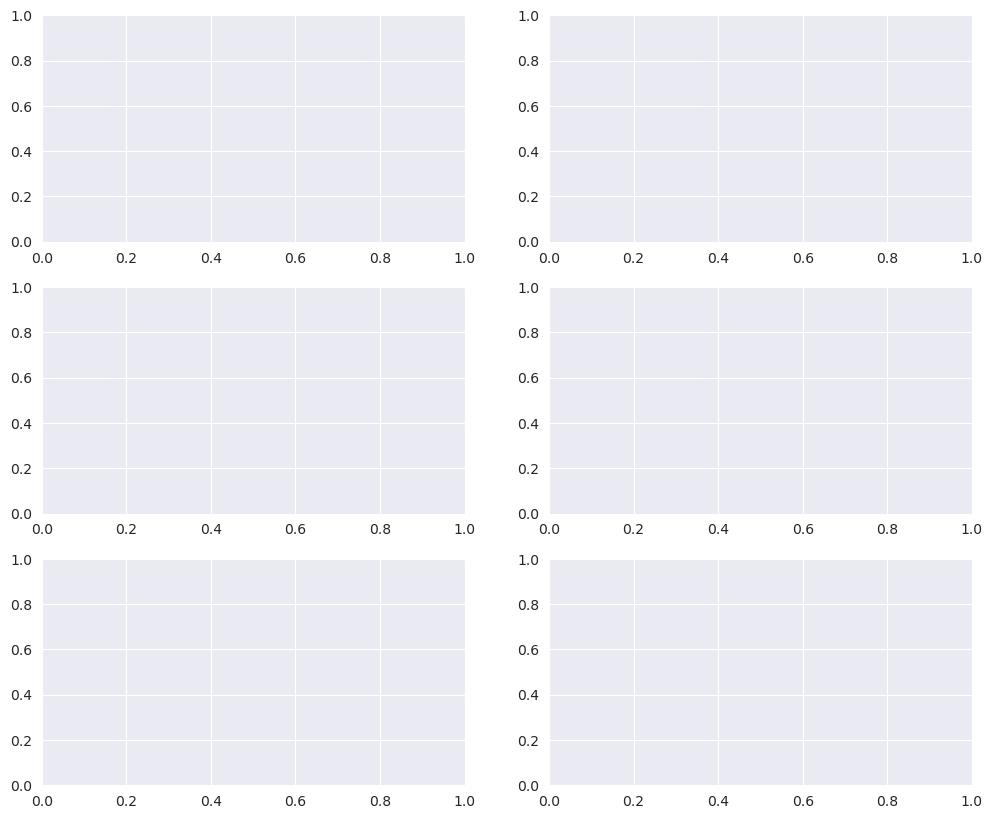

In [57]:
# Summary statistics for each ECG
summary_stats = df.describe().T
summary_stats = pd.concat([summary_stats, df_labels], axis=1)

# Plotting the distributions of summary statistics
stats_to_plot = ['mean', 'std', 'min', 'max', '25%', '75%']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Feature extraction

## ECG feature engineering

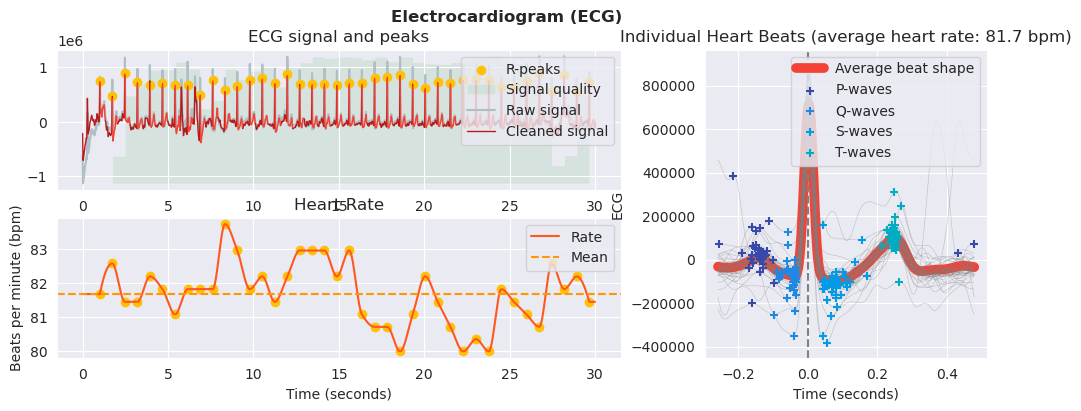

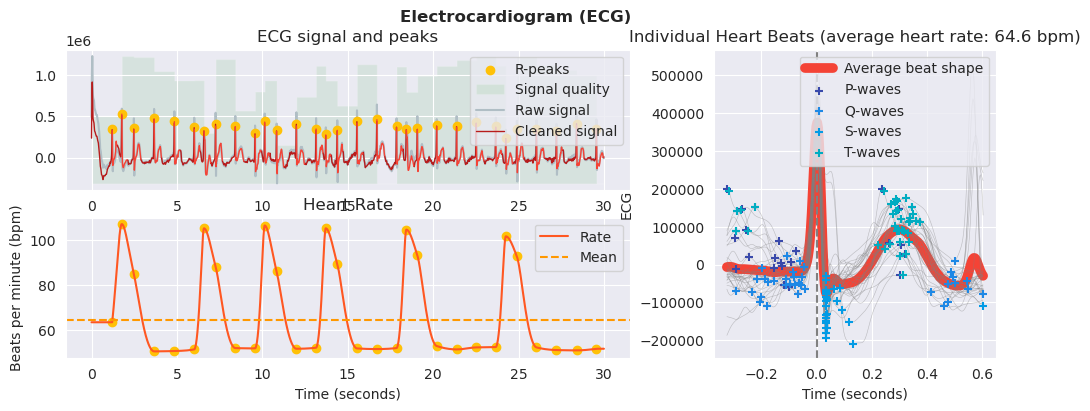

In [58]:
# Select an ECG in Normal Sinus Rhythm and one in AF and process them
selected_sinus_indices = random.sample(sinus_indices, 1)
selected_af_indices = random.sample(af_indices, 1)

ecg_NSR = df.iloc[selected_sinus_indices[0]].astype(float)
signals_NSR, info_NSR = nk.ecg_process(ecg_NSR, sampling_rate=sampling_frequency)

plt.rcParams['figure.figsize'] = [12, 4]
nk.ecg_plot(signals_NSR, info_NSR)

ecg_AF = df.iloc[selected_af_indices[0]].astype(float)
signals_AF, info_AF = nk.ecg_process(ecg_AF, sampling_rate=sampling_frequency)

nk.ecg_plot(signals_AF, info_AF)

#### R-peaks**

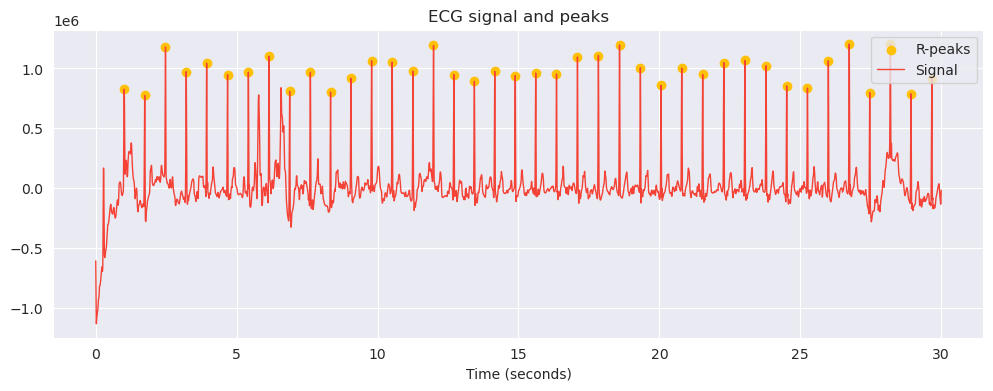

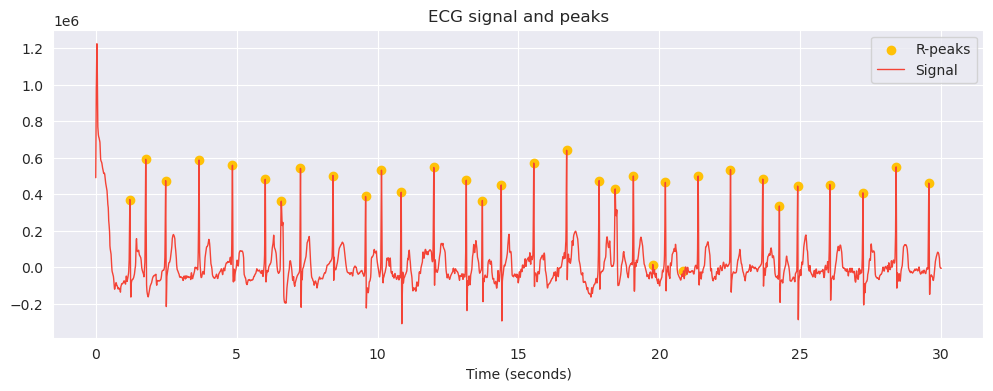

In [59]:
# Find R-peaks
peaks_NSR, info_NSR = nk.ecg_peaks(ecg_NSR, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)
peaks_AF, info_AF = nk.ecg_peaks(ecg_AF, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)

#### Time-domain features

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,734.615385,8.467875,NaN,NaN,NaN,NaN,NaN,NaN,8.532703,8.643127,0.011527,0.011615,733.333333,9.884,0.013478,11.666667,0.992402,726.666667,743.333333,0.0,0.0,716.666667,753.333333,2.4375,31.25


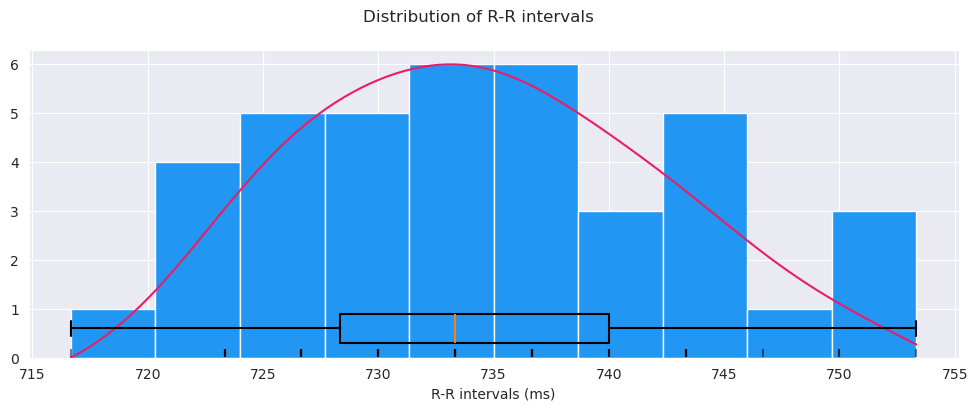

In [60]:
# Time domain features NSR
hrv_time_NSR = nk.hrv_time(peaks_NSR, sampling_rate=sampling_frequency, show=True)
hrv_time_NSR

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,885.833333,284.324011,NaN,NaN,NaN,NaN,NaN,NaN,332.529676,337.459693,0.320968,0.375386,923.333333,365.708,0.396074,525.0,0.855033,573.333333,1159.333333,62.5,71.875,440.0,1186.666667,6.4,125.0


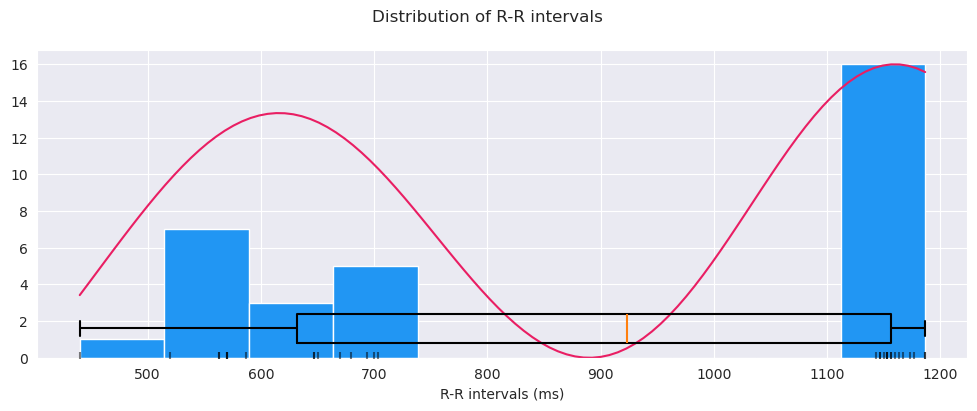

In [61]:
# Time domain features AF
hrv_time_AF = nk.hrv_time(peaks_AF, sampling_rate=sampling_frequency, show=True)
hrv_time_AF

### FULL HRV feature extraction for all ECGs (TRAIN)

In [62]:
#Getting all the ECG readouts so we can extract P-wave information

def get_ECG_readout():
    test_run = 0
    ecg_full = pd.DataFrame()  # Initialize an empty DataFrame

    for i in tqdm(train_idx):

        ecg = df.iloc[i].astype(float)
        signals, info = nk.ecg_process(ecg, sampling_rate=sampling_frequency)

        # Assign the current ecg_index to the signals DataFrame before concatenation
        signals["ecg_index"] = i

        ecg_full = pd.concat([ecg_full, signals], ignore_index=True)

        test_run += 1

        if test_run == 10:
            break  # Stop after 10 iterations for the example

    return ecg_full

In [63]:
ecg_full = get_ECG_readout()

  0%|          | 9/3619 [00:01<09:10,  6.55it/s]


In [64]:
def get_ECG_metrics(ecg_full):
    ecg_metrics_list = []

    for i in tqdm(train_idx[:10]):
        mean_quality = ecg_full.loc[ecg_full.ecg_index == i]['ECG_Quality'].mean()
        mean_pwave_amplitude = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)][
            'ECG_Clean'].mean()  #You could consider taking sqrt, mean and then **2
        #(more robust) to outliers
        stdev_pwave = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)]['ECG_Quality'].std()
        #Perhaps I could add something about irregularly irregular rhythm, but it's (really) difficult mathematically
        ecg_metrics_list.append({
            'Mean_Quality': mean_quality,
            'Mean_PWave_Amplitude': mean_pwave_amplitude,
            'STDEV_Pwave': stdev_pwave,
            'ecg_index': i
        })

    return pd.DataFrame(ecg_metrics_list)

In [65]:
ecg_metrics = get_ECG_metrics(ecg_full)

100%|██████████| 10/10 [00:00<00:00, 933.85it/s]


In [66]:
#FULL HRV feature extraction for all ECGs (TRAIN)

hrv_features_train = []

for i in tqdm(train_idx, desc="HRV (ALL FEATURES): TRAIN SET"):
    # Grab raw ECG
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Ensure row is a proper 1-row DataFrame and add ecg_index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_train.append(hrv_full)

    except Exception as e:
        print(f"Error processing TRAIN ECG {i}: {e}")

        if hrv_features_train:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_train[0].shape[1],
                index=hrv_features_train[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_train.append(empty)

# Combine to single DataFrame
hrv_train = pd.concat(hrv_features_train, ignore_index=True)

print("hrv_train shape:", hrv_train.shape)
hrv_train.head()

HRV (ALL FEATURES): TRAIN SET: 100%|██████████| 3619/3619 [00:58<00:00, 61.78it/s]


hrv_train shape: (3619, 84)


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,ecg_index,HRV_DFA_alpha2
0,747.350427,42.067750,NaN,NaN,NaN,NaN,NaN,NaN,29.264872,29.512262,0.056289,0.039158,743.333333,44.478,0.059836,61.666667,1.437483,712.000000,781.333333,10.256410,43.589744,683.333333,846.666667,9.750000,70.3125,NaN,NaN,NaN,0.012784,0.008231,0.021015,NaN,NaN,0.608332,-4.359576,20.868321,54.062882,0.386001,3544.349678,2.590668,4.256507,560.235819,0.615385,0.628571,0.863636,0.200000,56.321839,55.978330,56.674886,48.571429,0.656538,0.343462,16.992314,12.290283,0.577236,0.422764,41.074844,35.151848,0.587608,0.412392,31.431525,26.331573,1.371457,0.469367,1.474763,1.256436,0.999597,0.903996,-0.965152,0.000100,0.016083,0.168523,1.945910,4.631305,1.126252,0.888837,0.000000,0.000000,2.613851,1.637924,2.317564,0.677616,2453,NaN
1,812.037037,21.999679,NaN,NaN,NaN,NaN,NaN,NaN,28.183075,28.584077,0.027092,0.034707,813.333333,17.297,0.021267,20.833333,0.780599,803.333333,830.000000,5.555556,13.888889,753.333333,870.000000,3.600000,62.5000,NaN,NaN,NaN,0.010306,0.021925,0.032231,NaN,NaN,0.319766,-4.574982,20.211995,23.579533,0.857184,1497.249799,1.166611,3.882264,110.032562,0.750000,0.787879,1.000000,0.375000,52.173913,52.211472,52.135770,48.484848,0.603517,0.396483,15.707706,12.731516,0.378606,0.621394,14.508708,18.587410,0.473908,0.526092,15.120096,15.930840,0.285699,1.296953,0.841277,0.233056,0.853170,1.276766,-0.968962,0.002903,0.196206,0.450484,1.203973,3.718129,0.996761,0.575646,0.703353,0.703353,1.689850,1.860630,2.172865,1.005263,3560,NaN
2,939.784946,19.868745,NaN,NaN,NaN,NaN,NaN,NaN,29.122983,29.619986,0.021142,0.030989,943.333333,29.652,0.031433,38.333333,0.682236,920.000000,960.000000,0.000000,61.290323,900.000000,966.666667,3.444444,54.6875,NaN,NaN,NaN,0.117935,0.005697,0.123632,NaN,NaN,0.953919,-2.137619,20.944493,18.692238,1.120491,1229.931743,0.892466,3.796851,66.728710,0.580645,0.620690,0.944444,0.000000,49.553571,49.545035,49.561989,44.827586,0.483406,0.516594,14.562588,15.054181,0.577184,0.422816,14.200984,12.154497,0.524982,0.475018,14.382922,13.681377,0.402738,0.242395,0.432249,0.464418,0.671407,-0.171609,-0.367287,0.000002,0.002412,0.337255,1.252763,3.744204,1.690752,0.000000,0.000000,0.000000,2.059730,2.079210,6.133802,1.118689,322,NaN
3,1015.714286,142.461769,NaN,NaN,NaN,NaN,NaN,NaN,138.959982,141.080262,0.140258,0.136810,1050.000000,17.297,0.016473,24.166667,1.025200,1032.000000,1066.666667,7.142857,35.714286,393.333333,1103.333333,4.000000,656.2500,NaN,NaN,NaN,0.027954,0.003294,0.031248,NaN,NaN,0.894583,-3.577190,99.758810,166.429080,0.599407,52159.130937,1.668315,5.424300,1110.624266,0.535714,0.560000,0.857143,0.111111,38.369305,42.016819,35.993613,56.000000,0.172282,0.827718,41.561406,91.098472,0.696265,0.303735,138.872604,91.722618,0.557004,0.442996,102.501099,91.411078,-0.209973,2.725363,0.738260,0.319948,0.028157,0.752240,-0.653489,0.009860,0.762557,0.287647,0.323787,3.753434,0.442822,0.000000,0.000000,0.000000,0.892699,1.869363,1.333140,0.858456,33,NaN
4,676.991870,128.752141,NaN,NaN,NaN,NaN,NaN,NaN,179.541082,181.828243,0.190183,0.265204,710.000000,14.826,0.020882,40.000000,0.717118,586.666667,720.000000,46.341463,48.7804

In [67]:
# Merge our new dataframe with our extra variables
hrv_train = pd.merge(hrv_train, ecg_metrics, on='ecg_index', how='left')
hrv_train.head()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,ecg_index,HRV_DFA_alpha2,Mean_Quality,Mean_PWave_Amplitude,STDEV_Pwave
0,747.350427,42.067750,NaN,NaN,NaN,NaN,NaN,NaN,29.264872,29.512262,0.056289,0.039158,743.333333,44.478,0.059836,61.666667,1.437483,712.000000,781.333333,10.256410,43.589744,683.333333,846.666667,9.750000,70.3125,NaN,NaN,NaN,0.012784,0.008231,0.021015,NaN,NaN,0.608332,-4.359576,20.868321,54.062882,0.386001,3544.349678,2.590668,4.256507,560.235819,0.615385,0.628571,0.863636,0.200000,56.321839,55.978330,56.674886,48.571429,0.656538,0.343462,16.992314,12.290283,0.577236,0.422764,41.074844,35.151848,0.587608,0.412392,31.431525,26.331573,1.371457,0.469367,1.474763,1.256436,0.999597,0.903996,-0.965152,0.000100,0.016083,0.168523,1.945910,4.631305,1.126252,0.888837,0.000000,0.000000,2.613851,1.637924,2.317564,0.677616,2453,NaN,0.784017,36673.581497,0.241833
1,812.037037,21.999679,NaN,NaN,NaN,NaN,NaN,NaN,28.183075,28.584077,0.027092,0.034707,813.333333,17.297,0.021267,20.833333,0.780599,803.333333,830.000000,5.555556,13.888889,753.333333,870.000000,3.600000,62.5000,NaN,NaN,NaN,0.010306,0.021925,0.032231,NaN,NaN,0.319766,-4.574982,20.211995,23.579533,0.857184,1497.249799,1.166611,3.882264,110.032562,0.750000,0.787879,1.000000,0.375000,52.173913,52.211472,52.135770,48.484848,0.603517,0.396483,15.707706,12.731516,0.378606,0.621394,14.508708,18.587410,0.473908,0.526092,15.120096,15.930840,0.285699,1.296953,0.841277,0.233056,0.853170,1.276766,-0.968962,0.002903,0.196206,0.450484,1.203973,3.718129,0.996761,0.575646,0.703353,0.703353,1.689850,1.860630,2.172865,1.005263,3560,NaN,0.663560,30358.997255,0.266710
2,939.784946,19.868745,NaN,NaN,NaN,NaN,NaN,NaN,29.122983,29.619986,0.021142,0.030989,943.333333,29.652,0.031433,38.333333,0.682236,920.000000,960.000000,0.000000,61.290323,900.000000,966.666667,3.444444,54.6875,NaN,NaN,NaN,0.117935,0.005697,0.123632,NaN,NaN,0.953919,-2.137619,20.944493,18.692238,1.120491,1229.931743,0.892466,3.796851,66.728710,0.580645,0.620690,0.944444,0.000000,49.553571,49.545035,49.561989,44.827586,0.483406,0.516594,14.562588,15.054181,0.577184,0.422816,14.200984,12.154497,0.524982,0.475018,14.382922,13.681377,0.402738,0.242395,0.432249,0.464418,0.671407,-0.171609,-0.367287,0.000002,0.002412,0.337255,1.252763,3.744204,1.690752,0.000000,0.000000,0.000000,2.059730,2.079210,6.133802,1.118689,322,NaN,0.790269,57731.227708,0.219140
3,1015.714286,142.461769,NaN,NaN,NaN,NaN,NaN,NaN,138.959982,141.080262,0.140258,0.136810,1050.000000,17.297,0.016473,24.166667,1.025200,1032.000000,1066.666667,7.142857,35.714286,393.333333,1103.333333,4.000000,656.2500,NaN,NaN,NaN,0.027954,0.003294,0.031248,NaN,NaN,0.894583,-3.577190,99.758810,166.429080,0.599407,52159.130937,1.668315,5.424300,1110.624266,0.535714,0.560000,0.857143,0.111111,38.369305,42.016819,35.993613,56.000000,0.172282,0.827718,41.561406,91.098472,0.696265,0.303735,138.872604,91.722618,0.557004,0.442996,102.501099,91.411078,-0.209973,2.725363,0.738260,0.319948,0.028157,0.752240,-0.653489,0.009860,0.762557,0.287647,0.323787,3.753434,0.442822,0.000000,0.000000,0.000000,0.892699,1.869363,1.333140,0.858456,33,NaN,0.722554,86459.064945,0.285809
4,6

In [68]:
# Remove all columns from the dataframe that contain more than 50% NaN
threshold = 0.5
hrv_train_clean = hrv_train.dropna(thresh=len(hrv_train) * threshold, axis=1)

# Remove all rows that are all NaN
hrv_train_clean = hrv_train_clean.dropna(how='all')

hrv_train_clean.to_csv("hrv_train.csv", index=False)
hrv_train_clean.head()

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_HF,HRV_VHF,HRV_TP,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,ecg_index
0,747.350427,42.067750,29.264872,29.512262,0.056289,0.039158,743.333333,44.478,0.059836,61.666667,1.437483,712.000000,781.333333,10.256410,43.589744,683.333333,846.666667,9.750000,70.3125,0.012784,0.008231,0.021015,0.608332,-4.359576,20.868321,54.062882,0.386001,3544.349678,2.590668,4.256507,560.235819,0.615385,0.628571,0.863636,0.200000,56.321839,55.978330,56.674886,48.571429,0.656538,0.343462,16.992314,12.290283,0.577236,0.422764,41.074844,35.151848,0.587608,0.412392,31.431525,26.331573,1.371457,0.469367,1.474763,1.256436,0.999597,0.903996,-0.965152,0.000100,0.016083,0.168523,1.945910,4.631305,1.126252,0.888837,0.000000,0.000000,2.613851,1.637924,2.317564,0.677616,2453
1,812.037037,21.999679,28.183075,28.584077,0.027092,0.034707,813.333333,17.297,0.021267,20.833333,0.780599,803.333333,830.000000,5.555556,13.888889,753.333333,870.000000,3.600000,62.5000,0.010306,0.021925,0.032231,0.319766,-4.574982,20.211995,23.579533,0.857184,1497.249799,1.166611,3.882264,110.032562,0.750000,0.787879,1.000000,0.375000,52.173913,52.211472,52.135770,48.484848,0.603517,0.396483,15.707706,12.731516,0.378606,0.621394,14.508708,18.587410,0.473908,0.526092,15.120096,15.930840,0.285699,1.296953,0.841277,0.233056,0.853170,1.276766,-0.968962,0.002903,0.196206,0.450484,1.203973,3.718129,0.996761,0.575646,0.703353,0.703353,1.689850,1.860630,2.172865,1.005263,3560
2,939.784946,19.868745,29.122983,29.619986,0.021142,0.030989,943.333333,29.652,0.031433,38.333333,0.682236,920.000000,960.000000,0.000000,61.290323,900.000000,966.666667,3.444444,54.6875,0.117935,0.005697,0.123632,0.953919,-2.137619,20.944493,18.692238,1.120491,1229.931743,0.892466,3.796851,66.728710,0.580645,0.620690,0.944444,0.000000,49.553571,49.545035,49.561989,44.827586,0.483406,0.516594,14.562588,15.054181,0.577184,0.422816,14.200984,12.154497,0.524982,0.475018,14.382922,13.681377,0.402738,0.242395,0.432249,0.464418,0.671407,-0.171609,-0.367287,0.000002,0.002412,0.337255,1.252763,3.744204,1.690752,0.000000,0.000000,0.000000,2.059730,2.079210,6.133802,1.118689,322
3,1015.714286,142.461769,138.959982,141.080262,0.140258,0.136810,1050.000000,17.297,0.016473,24.166667,1.025200,1032.000000,1066.666667,7.142857,35.714286,393.333333,1103.333333,4.000000,656.2500,0.027954,0.003294,0.031248,0.894583,-3.577190,99.758810,166.429080,0.599407,52159.130937,1.668315,5.424300,1110.624266,0.535714,0.560000,0.857143,0.111111,38.369305,42.016819,35.993613,56.000000,0.172282,0.827718,41.561406,91.098472,0.696265,0.303735,138.872604,91.722618,0.557004,0.442996,102.501099,91.411078,-0.209973,2.725363,0.738260,0.319948,0.028157,0.752240,-0.653489,0.009860,0.762557,0.287647,0.323787,3.753434,0.442822,0.000000,0.000000,0.000000,0.892699,1.869363,1.333140,0.858456,33
4,676.991870,128.752141,179.541082,181.828243,0.190183,0.265204,710.000000,14.826,0.020882,40.000000,0.717118,586.666667,720.000000,46.341463,48.780488,396.666667,906.666667,3.153846,320.3125,0.040705,0.061765,0.102469,0.397239,-3.201411,128.571984,131.968657,0.974262,53304.885527,1.026418,5.433737,541.820263,0.682927,0.714286,0.960000,0.272727,50.077760,50.334939,49.900405,42.857143,0.473140,0.526860,88.438496,93.324175,0.490901,0.509099,92.462994,94.161145,0.482252,0.517748,90.47

### FULL HRV feature extraction for all ECGs (TEST)

In [69]:
hrv_features_test = []

for i in tqdm(test_idx, desc="HRV (ALL FEATURES): TEST SET"):
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Same as TRAIN: keep as 1-row DataFrame, add index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_test.append(hrv_full)

    except Exception as e:
        print(f"Error processing TEST ECG {i}: {e}")

        if hrv_features_test:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_test[0].shape[1],
                index=hrv_features_test[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_test.append(empty)

hrv_test = pd.concat(hrv_features_test, ignore_index=True)

print("hrv_test shape:", hrv_test.shape)
hrv_test.head()

HRV (ALL FEATURES): TEST SET: 100%|██████████| 905/905 [00:15<00:00, 59.74it/s]


hrv_test shape: (905, 84)


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,ecg_index,HRV_DFA_alpha2
0,1068.641975,172.129099,NaN,NaN,NaN,NaN,NaN,NaN,235.984934,240.146394,0.161073,0.220827,1190.000000,163.086,0.137047,328.333333,0.729407,890.000000,1238.000000,62.962963,85.185185,876.666667,1300.000000,4.500000,0.0000,NaN,NaN,NaN,0.110964,0.000357,0.111321,NaN,NaN,0.996794,-2.198547,169.809144,171.633878,0.989368,91561.723667,1.010746,5.668684,693.912881,0.444444,0.500000,0.923077,0.000000,45.862069,45.774102,45.965889,57.692308,0.515985,0.484015,122.237474,118.390127,0.398614,0.601386,108.362548,133.100512,0.456797,0.543203,115.508532,125.960249,0.263558,2.440202,0.710130,1.400539,-0.729552,-1.518728,-0.217069,0.017170,0.894035,0.263446,0.254234,4.236369,0.643233,0.000000,0.000000,0.000000,0.730424,2.056366,4.206339,1.056642,460,NaN
1,471.720430,110.902478,NaN,NaN,NaN,NaN,NaN,NaN,156.378645,157.665286,0.235102,0.331507,451.666667,96.369,0.213363,140.000000,0.709192,378.000000,563.333333,61.290323,77.419355,323.333333,876.666667,12.400000,93.7500,NaN,NaN,NaN,0.149402,0.063836,0.213238,NaN,NaN,0.700634,-1.901115,111.486193,110.654769,1.007514,38756.191472,0.992542,5.295311,439.318180,0.629032,0.644068,0.842105,0.384615,50.814176,51.343252,50.192216,38.983051,0.444955,0.555045,74.372063,83.064567,0.721759,0.278241,94.008323,58.368768,0.582311,0.417689,84.760747,71.786612,0.682713,2.542837,0.984898,1.583575,-1.458829,-1.511935,-0.264564,0.005000,0.514535,0.540191,2.772589,5.425892,1.673879,1.572833,1.264768,1.377608,2.231461,1.967520,2.634058,1.248461,1621,NaN
2,1081.923077,12.335066,NaN,NaN,NaN,NaN,NaN,NaN,13.840360,14.125102,0.011401,0.012792,1083.333333,14.826,0.013686,15.833333,0.891239,1073.333333,1090.000000,0.000000,11.538462,1060.000000,1110.000000,3.714286,39.0625,NaN,NaN,NaN,0.074530,0.006737,0.081267,NaN,NaN,0.917103,-2.596556,9.987956,14.218533,0.702460,446.150368,1.423568,3.356451,80.964182,0.730769,0.800000,1.000000,0.333333,49.397590,49.405345,49.389812,45.000000,0.433875,0.566125,6.579288,7.515416,0.623758,0.376242,11.229566,8.721440,0.561015,0.438985,9.202994,8.140792,0.841494,1.313795,1.100002,1.319227,-0.098312,-0.696731,-0.333136,0.001071,0.142204,0.014630,inf,3.162972,1.585425,NaN,NaN,NaN,2.056296,1.884233,2.687031,1.084717,4201,NaN
3,543.888889,120.649448,NaN,NaN,NaN,NaN,NaN,NaN,162.782411,164.269309,0.221827,0.299294,505.000000,116.137,0.229974,180.833333,0.741170,443.333333,667.333333,68.518519,83.333333,383.333333,850.000000,18.000000,39.0625,NaN,NaN,NaN,0.062163,0.016604,0.078767,NaN,NaN,0.789202,-2.778000,116.155942,124.675324,0.931667,45495.852811,1.073344,5.364942,535.278220,0.685185,0.716981,0.947368,0.250000,51.804368,51.821610,51.785365,50.943396,0.533712,0.466288,84.894983,79.351673,0.518078,0.481922,89.738311,86.550401,0.525346,0.474654,87.350222,83.029091,0.744078,1.243472,0.925432,1.365814,-1.023878,-2.015855,-0.145845,0.001057,0.128594,0.453157,1.421386,5.370538,1.575282,0.875207,1.187528,1.360120,1.619727,1.944765,3.266155,1.172292,1281,NaN
4,812.777778,49.444534,NaN,NaN,NaN,NaN,NaN,NaN,27.803163,28.161201,0.060834,0.034208,811.666667,44.478,0.054798,56.666667,1.778378,773.333333,853.333333,5.555556,33

In [70]:
# Merge our new dataframe with our extra variables
hrv_test = pd.merge(hrv_test, ecg_metrics, on='ecg_index', how='left')
hrv_test.head()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,ecg_index,HRV_DFA_alpha2,Mean_Quality,Mean_PWave_Amplitude,STDEV_Pwave
0,1068.641975,172.129099,NaN,NaN,NaN,NaN,NaN,NaN,235.984934,240.146394,0.161073,0.220827,1190.000000,163.086,0.137047,328.333333,0.729407,890.000000,1238.000000,62.962963,85.185185,876.666667,1300.000000,4.500000,0.0000,NaN,NaN,NaN,0.110964,0.000357,0.111321,NaN,NaN,0.996794,-2.198547,169.809144,171.633878,0.989368,91561.723667,1.010746,5.668684,693.912881,0.444444,0.500000,0.923077,0.000000,45.862069,45.774102,45.965889,57.692308,0.515985,0.484015,122.237474,118.390127,0.398614,0.601386,108.362548,133.100512,0.456797,0.543203,115.508532,125.960249,0.263558,2.440202,0.710130,1.400539,-0.729552,-1.518728,-0.217069,0.017170,0.894035,0.263446,0.254234,4.236369,0.643233,0.000000,0.000000,0.000000,0.730424,2.056366,4.206339,1.056642,460,NaN,NaN,NaN,NaN
1,471.720430,110.902478,NaN,NaN,NaN,NaN,NaN,NaN,156.378645,157.665286,0.235102,0.331507,451.666667,96.369,0.213363,140.000000,0.709192,378.000000,563.333333,61.290323,77.419355,323.333333,876.666667,12.400000,93.7500,NaN,NaN,NaN,0.149402,0.063836,0.213238,NaN,NaN,0.700634,-1.901115,111.486193,110.654769,1.007514,38756.191472,0.992542,5.295311,439.318180,0.629032,0.644068,0.842105,0.384615,50.814176,51.343252,50.192216,38.983051,0.444955,0.555045,74.372063,83.064567,0.721759,0.278241,94.008323,58.368768,0.582311,0.417689,84.760747,71.786612,0.682713,2.542837,0.984898,1.583575,-1.458829,-1.511935,-0.264564,0.005000,0.514535,0.540191,2.772589,5.425892,1.673879,1.572833,1.264768,1.377608,2.231461,1.967520,2.634058,1.248461,1621,NaN,NaN,NaN,NaN
2,1081.923077,12.335066,NaN,NaN,NaN,NaN,NaN,NaN,13.840360,14.125102,0.011401,0.012792,1083.333333,14.826,0.013686,15.833333,0.891239,1073.333333,1090.000000,0.000000,11.538462,1060.000000,1110.000000,3.714286,39.0625,NaN,NaN,NaN,0.074530,0.006737,0.081267,NaN,NaN,0.917103,-2.596556,9.987956,14.218533,0.702460,446.150368,1.423568,3.356451,80.964182,0.730769,0.800000,1.000000,0.333333,49.397590,49.405345,49.389812,45.000000,0.433875,0.566125,6.579288,7.515416,0.623758,0.376242,11.229566,8.721440,0.561015,0.438985,9.202994,8.140792,0.841494,1.313795,1.100002,1.319227,-0.098312,-0.696731,-0.333136,0.001071,0.142204,0.014630,inf,3.162972,1.585425,NaN,NaN,NaN,2.056296,1.884233,2.687031,1.084717,4201,NaN,NaN,NaN,NaN
3,543.888889,120.649448,NaN,NaN,NaN,NaN,NaN,NaN,162.782411,164.269309,0.221827,0.299294,505.000000,116.137,0.229974,180.833333,0.741170,443.333333,667.333333,68.518519,83.333333,383.333333,850.000000,18.000000,39.0625,NaN,NaN,NaN,0.062163,0.016604,0.078767,NaN,NaN,0.789202,-2.778000,116.155942,124.675324,0.931667,45495.852811,1.073344,5.364942,535.278220,0.685185,0.716981,0.947368,0.250000,51.804368,51.821610,51.785365,50.943396,0.533712,0.466288,84.894983,79.351673,0.518078,0.481922,89.738311,86.550401,0.525346,0.474654,87.350222,83.029091,0.744078,1.243472,0.925432,1.365814,-1.023878,-2.015855,-0.145845,0.001057,0.128594,0.453157,1.421386,5.370538,1.575282,0.875207,1.187528,1.360120,1.619727,1.944765,3.266155,1.172292,1281,NaN,NaN,NaN,NaN
4,812.777778,49.444534,NaN,NaN,NaN,NaN,NaN,NaN,27.803163,28.161201,0.0

In [71]:
# Remove all columns from the dataframe that contain more than 50% NaN
threshold = 0.5
hrv_test_clean = hrv_test.dropna(thresh=len(hrv_test) * threshold, axis=1)

# Remove all rows that are all NaN
hrv_test_clean = hrv_test_clean.dropna(how='all')

hrv_test_clean.head()

hrv_test.to_csv("hrv_test.csv", index=False)

### Feature exploration

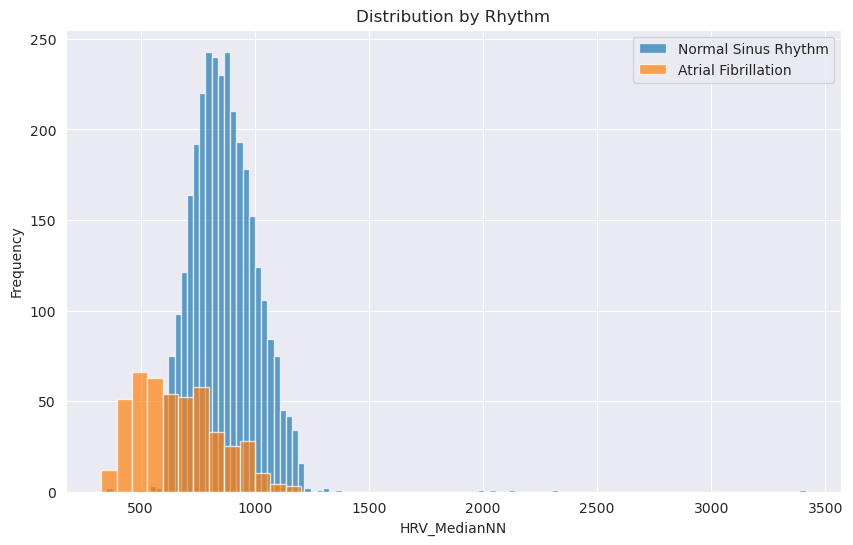

In [72]:
# Merge the HRV data with the rhythm labels
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on='ecg_index', right_index=True
).reset_index(drop=True)

plt.figure(figsize=(10, 6))

selectedMetric = 'HRV_MedianNN'
rhythms = hrv_train_with_labels['label'].unique()
for rhythm in rhythms:
    subset = hrv_train_with_labels[hrv_train_with_labels['label'] == rhythm]
    plt.hist(subset[selectedMetric], alpha=0.7, label=rhythm, bins='auto')

plt.xlabel(selectedMetric)
plt.ylabel('Frequency')
plt.title('Distribution by Rhythm')
plt.legend()
plt.show()

# Preprocessing

## Missingness

In [73]:
def check_missing_hrv(df):
    """
    Summarize missingness across HRV features.
    """
    missing = df.isna().sum()
    out = pd.DataFrame({
        "feature": df.columns,
        "missing_n": missing,
        "missing_%": (missing / len(df)) * 100
    })
    display(out.sort_values("missing_%", ascending=False))
    return out

In [74]:
check_missing_hrv(hrv_train_clean)

,feature,missing_n,missing_%
HRV_CMSEn,HRV_CMSEn,781,21.580547
HRV_RCMSEn,HRV_RCMSEn,781,21.580547
HRV_MSEn,HRV_MSEn,758,20.945012
HRV_HFD,HRV_HFD,13,0.359215
HRV_DFA_alpha1,HRV_DFA_alpha1,6,0.165792
...,...,...,...
HRV_ApEn,HRV_ApEn,0,0.000000
HRV_FuzzyEn,HRV_FuzzyEn,0,0.000000
HRV_KFD,HRV_KFD,0,0.000000
HRV_LZC,HRV_LZC,0,0.000000


,feature,missing_n,missing_%
HRV_MeanNN,HRV_MeanNN,0,0.000000
HRV_SDNN,HRV_SDNN,0,0.000000
HRV_RMSSD,HRV_RMSSD,0,0.000000
HRV_SDSD,HRV_SDSD,0,0.000000
HRV_CVNN,HRV_CVNN,0,0.000000
...,...,...,...
HRV_CD,HRV_CD,1,0.027632
HRV_HFD,HRV_HFD,13,0.359215
HRV_KFD,HRV_KFD,0,0.000000
HRV_LZC,HRV_LZC,0,0.000000


## Outlier Detection

In [75]:
# Function to identify outliers in the data
def identify_outliers(df, column_name, threshold=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers
    row_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index.tolist()
    outlier_values = df.loc[row_indices, column_name].tolist()

    return row_indices, outlier_values, lower_bound, upper_bound

In [76]:
# Outlier detection ONLY ON TRAIN

# Merge labels with TRAIN features (cleaned hrv_train)
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on="ecg_index", right_index=True
)

# Outlier detection ONLY on TRAIN
train_outlier_idx, outlier_values, iqr_lower, iqr_upper = identify_outliers(
    hrv_train_with_labels,
    "HRV_MedianNN",
    threshold=1.5
)

# ecg_index as (int)
hrv_train_with_labels["ecg_index"] = hrv_train_with_labels["ecg_index"].astype(int)

print("Train outliers detected:", len(train_outlier_idx))
print("Row indices (in hrv_train_with_labels) with outliers:", train_outlier_idx)
print("Outlier HRV_MedianNN values:", outlier_values)

Train outliers detected: 53
Row indices (in hrv_train_with_labels) with outliers: [44, 256, 358, 446, 447, 519, 522, 554, 557, 581, 661, 773, 870, 878, 926, 1059, 1278, 1402, 1516, 1841, 1945, 1991, 2027, 2058, 2070, 2145, 2285, 2297, 2305, 2579, 2613, 2646, 2688, 2803, 2806, 2865, 2955, 2995, 2997, 3011, 3018, 3025, 3119, 3128, 3148, 3186, 3287, 3290, 3322, 3422, 3467, 3470, 3614]
Outlier HRV_MedianNN values: [398.33333333333337, 426.66666666666663, 398.33333333333337, 1310.0, 425.0, 410.0, 380.0, 405.0, 386.6666666666667, 396.6666666666667, 396.6666666666667, 350.0, 326.6666666666667, 376.66666666666663, 360.0, 403.33333333333337, 1300.0, 3413.333333333333, 385.0, 430.0, 426.6666666666667, 2323.333333333333, 396.6666666666667, 430.0, 2050.0, 390.0, 426.6666666666667, 396.6666666666667, 361.66666666666663, 396.6666666666667, 2116.6666666666665, 400.0, 390.0, 393.3333333333333, 413.3333333333333, 393.3333333333333, 420.0, 418.33333333333337, 376.66666666666663, 1360.0, 1280.0, 376.6666

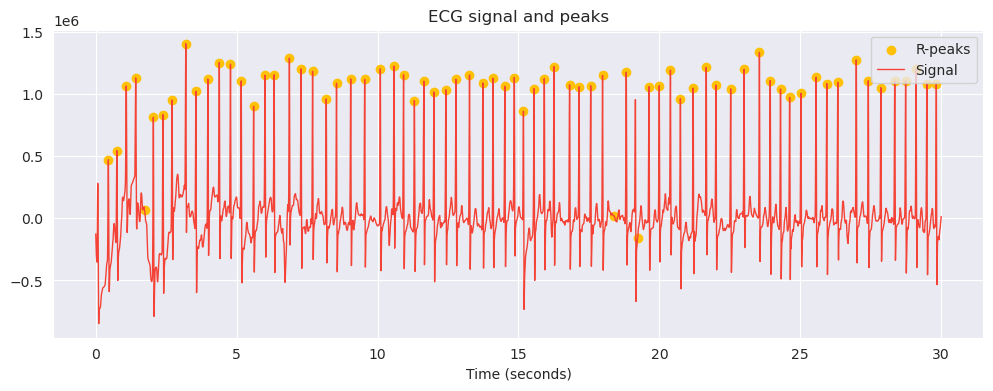

In [77]:
# Visualise one outlier ECG

example_outlier_row = train_outlier_idx[0]

# Single row
row = hrv_train_with_labels.loc[example_outlier_row]

# Extract ECG index value
ecg_index_values = row.filter(like="ecg_index").values

# Use first value
ecg_idx = int(ecg_index_values[0])

# Extract raw ECG from df
ecg_raw = df.iloc[ecg_idx].astype(float).values

# Visualise R-Peaks
peaks_outlier, info_outlier = nk.ecg_peaks(
    ecg_raw,
    sampling_rate=sampling_frequency,
    correct_artifacts=True,
    show=True
)

In [78]:
hrv_train_with_labels.loc[example_outlier_row]

HRV_MeanNN                 407.962963
HRV_SDNN                    72.335411
HRV_RMSSD                   94.653639
HRV_SDSD                    95.326167
HRV_CVNN                     0.177309
                         ...         
HRV_KFD                      2.588807
HRV_LZC                      1.114014
ecg_index                        1644
label             Atrial Fibrillation
classification                      1
Name: 44, Length: 74, dtype: object

#### **Outliers TEST set** done the same way as for TRAINING

In [79]:
# Align TEST columns to TRAIN columns

# Align TEST columns to TRAIN columns (no leakage, same feature space)
train_cols = hrv_train_clean.columns  # already cleaned on TRAIN
shared_cols = [c for c in train_cols if c in hrv_test.columns]

hrv_test_aligned = hrv_test[shared_cols].copy()

# Merge TEST HRV with labels
hrv_test_with_labels = pd.merge(
    hrv_test_aligned,
    df_labels[["label", "classification"]],
    left_on="ecg_index",
    right_index=True
)

In [80]:
# Same IQR bounds as on hrv_train

Q1 = hrv_train_clean["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_clean["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hrv_test_clean = hrv_test_with_labels[
    (hrv_test_with_labels["HRV_MedianNN"] >= lower_bound) &
    (hrv_test_with_labels["HRV_MedianNN"] <= upper_bound)
    ].copy()

print("hrv_test shape:", hrv_test.shape)
print("hrv_test_with_labels shape:", hrv_test_with_labels.shape)
print("hrv_test_clean shape:", hrv_test_clean.shape)

hrv_test shape: (905, 87)
hrv_test_with_labels shape: (905, 74)
hrv_test_clean shape: (889, 74)


## Distribution TRAIN + TEST | Sanity check

In [81]:
print(hrv_train_clean.columns[:5])
print(hrv_test_clean.columns[:5])
print(hrv_test_clean[["HRV_MedianNN", "classification"]].head())

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
   HRV_MedianNN  classification
0   1190.000000               0
1    451.666667               1
2   1083.333333               0
3    505.000000               1
4    811.666667               0


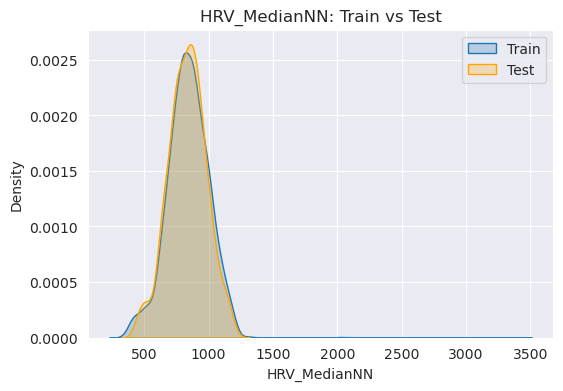

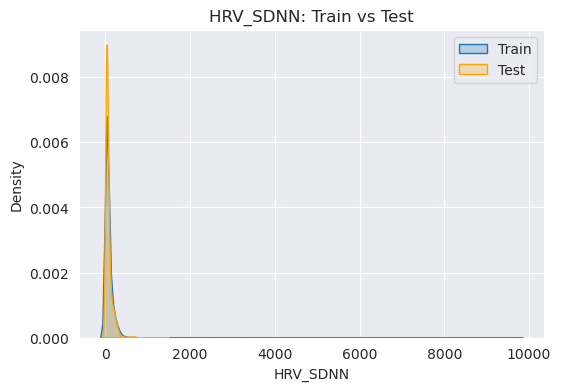

In [82]:
for feat in ["HRV_MedianNN", "HRV_SDNN"]:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=hrv_train_clean, x=feat, label="Train", fill=True, common_norm=False
    )
    sns.kdeplot(
        data=hrv_test_clean, x=feat, label="Test", fill=True, common_norm=False, color="orange"
    )
    plt.title(f"{feat}: Train vs Test")
    plt.legend()
    plt.show()

### Outlier Handling TRAIN

#### Winsorising outliers

In [83]:
Q1 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_clip = Q1 - 1.5 * IQR
upper_clip = Q3 + 1.5 * IQR

hrv_train_winsor = hrv_train_with_labels.copy()
hrv_train_winsor["HRV_MedianNN_winsor"] = hrv_train_with_labels["HRV_MedianNN"].clip(
    lower=lower_clip, upper=upper_clip
)

print("Shape after winsorizing (same as original):", hrv_train_winsor.shape)

Shape after winsorizing (same as original): (3619, 75)


### Outlier Handling Comparison

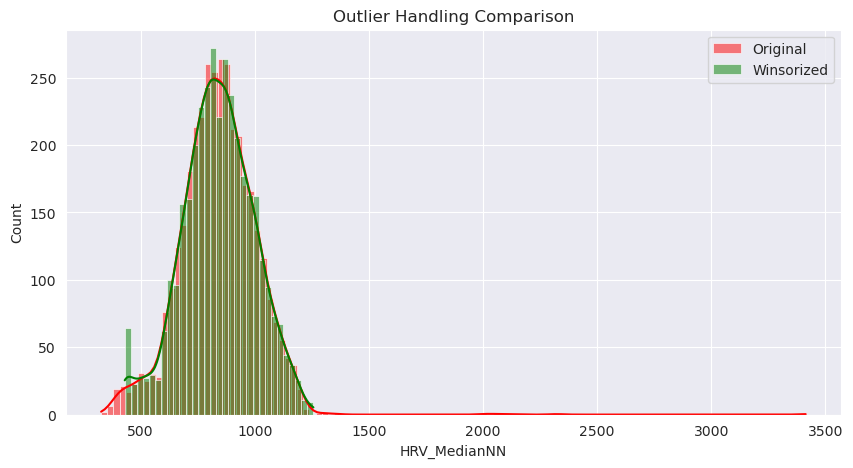

In [84]:
plt.figure(figsize=(10, 5))
sns.histplot(hrv_train_with_labels["HRV_MedianNN"], kde=True, color="red", label="Original")
sns.histplot(hrv_train_winsor["HRV_MedianNN_winsor"], kde=True, color="green", label="Winsorized")

plt.legend()
plt.title("Outlier Handling Comparison")
plt.show()

# Final Preprocessing: Building ML Matrices (X_train, X_test)

In [85]:
# Select HRV feature columns only
feature_cols = [col for col in hrv_train_with_labels.columns if col.startswith("HRV_")]

# TRAIN data
x_train = hrv_train_with_labels[feature_cols].copy()
y_train = hrv_train_with_labels["classification"].copy()

# TEST data
x_test = hrv_test_clean[feature_cols].copy()
y_test = hrv_test_clean["classification"].copy()

In [86]:
# Replace +/- inf with NaN in both TRAIN and TEST
for df_ in (x_train, x_test):
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns that are all-NaN (if any)
all_nan_cols = x_train.columns[x_train.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping all-NaN columns before imputation:", list(all_nan_cols))
    x_train.drop(columns=all_nan_cols, inplace=True)
    x_test.drop(columns=all_nan_cols, inplace=True)

## Imputation

In [87]:
# Median imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# X_train: fit_transform
X_train_imputed = imputer.fit_transform(x_train)

# X_test: only transform (so test set remains untouched)
X_test_imputed = imputer.transform(x_test)

## Normalisation

In [88]:
#Temporarily convert to DataFrame to calculate Skewness easily
temp_df = pd.DataFrame(X_train_imputed, columns=feature_cols)
skewness = temp_df.skew().sort_values(ascending=False)

#Identify skewed columns (Threshold > 1.0)
skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()

#Apply Log Transform directly to the NumPy arrays
for col_name in skewed_cols:
    # Find the column index (integer position)
    col_idx = feature_cols.index(col_name)

    # Check for negative values (Log crashes on negatives)
    # We find the global minimum for this column across Train and Test
    min_val = min(X_train_imputed[:, col_idx].min(), X_test_imputed[:, col_idx].min())

    shift = 0
    if min_val < 0:
        # If negatives exist, calculate a shift to make the minimum 0
        shift = abs(min_val)

    # Apply transformation in-place: Log(x + shift + 1)
    X_train_imputed[:, col_idx] = np.log1p(X_train_imputed[:, col_idx] + shift)
    X_test_imputed[:, col_idx] = np.log1p(X_test_imputed[:, col_idx] + shift)

## Scaling

In [89]:
scaler = RobustScaler()

# X_train: fit_transform
X_train_scaled = scaler.fit_transform(X_train_imputed)

# X_test: only transform (so test set remains untouched)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert back to df with column names
x_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
x_test = pd.DataFrame(X_test_scaled, columns=feature_cols)

### **Sanity checks**

In [90]:
# Median X_train
print("Median of scaled features (should be ~0):")
print(x_train.median().round(3))

# IQR X_train
print("\nIQR of scaled features (should be ~1):")
print((x_train.quantile(0.75) - x_train.quantile(0.25)).round(3))

#Checking skewness of the datasets
skewness_train = x_train.skew().sort_values(ascending=False)
skewness_test = x_train.skew().sort_values(ascending=False)
# Filter for highly skewed columns (absolute skew > 1.0)
high_skew_cols_train = skewness_train[abs(skewness_train) > 1.0]
high_skew_cols_test = skewness_test[abs(skewness_test) > 1.0]

print(len(high_skew_cols_train))
print(len(high_skew_cols_test))

Median of scaled features (should be ~0):
HRV_MeanNN    0.0
HRV_SDNN      0.0
HRV_RMSSD     0.0
HRV_SDSD      0.0
HRV_CVNN      0.0
             ... 
HRV_RCMSEn    0.0
HRV_CD        0.0
HRV_HFD       0.0
HRV_KFD       0.0
HRV_LZC       0.0
Length: 71, dtype: float64

IQR of scaled features (should be ~1):
HRV_MeanNN    1.0
HRV_SDNN      1.0
HRV_RMSSD     1.0
HRV_SDSD      1.0
HRV_CVNN      1.0
             ... 
HRV_RCMSEn    0.0
HRV_CD        1.0
HRV_HFD       1.0
HRV_KFD       1.0
HRV_LZC       1.0
Length: 71, dtype: float64
15
15


# Final ML datasets (X_train, X_test, y_train, y_test

In [92]:
print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


In [93]:
if True:
    # Feature matrices (winsorised > imputation > scaling)
    x_train = X_train_scaled
    x_test = X_test_scaled

    # Target vectors (created earlier from HRV + labels AF(0/1))
    y_train = hrv_train_with_labels["classification"].copy()
    y_test = hrv_test_clean["classification"].copy()

    print("Final X_train shape:", x_train.shape)
    print("Final X_test shape:", x_test.shape)
    print("Final y_train shape:", y_train.shape)
    print("Final y_test shape:", y_test.shape)

Final X_train shape: (3619, 71)
Final X_test shape: (889, 71)
Final y_train shape: (3619,)
Final y_test shape: (889,)


# Machine Learning Training Setup

## Safety check

In [94]:
assert len(x_train) == len(y_train), "Misaligned TRAIN matrix and labels!"
assert len(x_test) == len(y_test), "Misaligned TEST matrix and labels!"

assert not np.isnan(x_train).any(), "NaNs detected in X_train!"
assert not np.isnan(x_test).any(), "NaNs detected in X_test!"

## Comparison framework

In [95]:
resultsTable = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC', 'ROC_AUC', 'cm'])


def modelResults(model, accuracy, f1, precision, recall, roc_auc, roc_cur, cm):
    print(
        f"Model {model} evaluated. \nAccuracy: {accuracy} \nF1 Score: {f1} \nPrecision: {precision} \nRecall: {recall} \nROC AUC: {roc_auc}")
    resultsTable.loc[len(resultsTable)] = [model, accuracy, f1, precision, recall, roc_cur, roc_auc, cm]
    resultsTable.to_csv("trainingResults.csv", index=False)

In [96]:
print(
    f"X train length: {len(x_train)}\n X test length: {len(x_test)} \n Y train length: {len(y_train)}\n Y test length: {len(y_test)}")

X train length: 3619
 X test length: 889 
 Y train length: 3619
 Y test length: 889


# Machine Learning Training

## Logistic Regression

### All features

Accuracy: 0.931
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       786
           1       0.64      0.93      0.76       103

    accuracy                           0.93       889
   macro avg       0.82      0.93      0.86       889
weighted avg       0.95      0.93      0.94       889



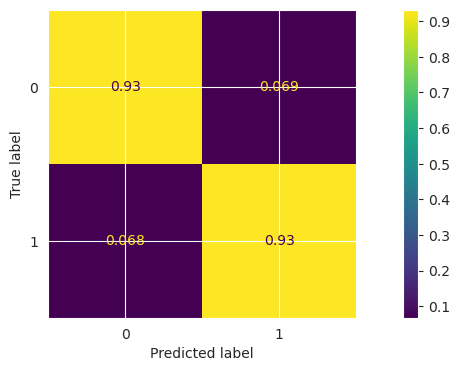

In [97]:
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(x_train, y_train)

y_pred_proba = model_LR.predict_proba(x_test)[:, 1]
y_pred = model_LR.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

f1_score_baseline = f1_score(y_test, y_pred, average='binary')

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_LR.classes_)
disp.plot();

In [98]:
modelResults(model_LR, accuracy, f1_score(y_test, y_pred), precision_score(y_test, y_pred),
             recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred_proba), roc_curve(y_test, y_pred_proba), cm)


Model LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='auto') evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.758893280632411 
Precision: 0.64 
Recall: 0.9320388349514563 
ROC AUC: 0.9732083302453123


### Select features

In [99]:
#Check if training set is a numpy array
if isinstance(x_train, np.ndarray):
    x_train = pd.DataFrame(x_train, columns=feature_cols)
    x_test = pd.DataFrame(x_test, columns=feature_cols)

coeffs = np.abs(model_LR.coef_[0])
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': coeffs
}).sort_values(by='Importance', ascending=False)
top_features = feature_importance_df['Feature'].head(10).tolist()
print(top_features)

['HRV_MeanNN', 'HRV_CVNN', 'HRV_FuzzyEn', 'HRV_Prc20NN', 'HRV_SD2d', 'HRV_IALS', 'HRV_SD1d', 'HRV_pNN50', 'HRV_ShanEn', 'HRV_SDRMSSD']


In [100]:
print(f"Baseline LR f1-score: {f1_score_baseline:.4f}")
#Kept for reproducibility purposes

if False:
    for k in range(5, len(top_features) + 1):
        top_k_features = top_features[:k]
        lr_k = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
        lr_k.fit(x_train[top_k_features], y_train)
        y_pred = lr_k.predict(x_test[top_k_features])
        y_pred_proba = lr_k.predict_proba(x_test[top_k_features])[:, 1]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred_proba)
        print(f"Top {k} Features -> F1 Score: {f1:.4f}")

top_k_features = top_features[:6]
lr_top10 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
lr_top10.fit(x_train[top_k_features], y_train)
y_pred_top10 = lr_top10.predict(x_test[top_k_features])
y_pred_top10_proba = lr_top10.predict_proba(x_test[top_k_features])[:, 1]
modelResults(
    "LR (Top 10 Features)",
    accuracy_score(y_test, y_pred_top10),
    f1_score(y_test, y_pred_top10),
    precision_score(y_test, y_pred_top10),
    recall_score(y_test, y_pred_top10),
    roc_auc_score(y_test, y_pred_top10_proba),
    roc_curve(y_test, y_pred_top10_proba),
    confusion_matrix(y_test, y_pred_top10, normalize='true')
)

Baseline LR f1-score: 0.7589
Model LR (Top 10 Features) evaluated. 
Accuracy: 0.9178852643419573 
F1 Score: 0.7181467181467182 
Precision: 0.5961538461538461 
Recall: 0.9029126213592233 
ROC AUC: 0.9641789569900443


### Remove features based on correlation

In [101]:
corr_matrix = x_train.corr().abs()
# Select only the upper triangle of the correlation matrix. k=1 excludes the diagonal (self-correlation=1.0) so we don't accidentally delete every feature and ensuring we check each pair (A vs B) only once and ignore mirror duplicates (B vs A).
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

if False:
    for threshold in [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]:
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        features_keep = [f for f in x_train.columns if f not in to_drop]
        lr_corr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
        lr_corr.fit(x_train[features_keep], y_train)
        y_pred = lr_corr.predict_proba(x_test[features_keep])
        y_pred_cm = lr_corr.predict(x_test[features_keep])

        f1 = f1_score(y_test, y_pred_cm, average='binary')
        rec = recall_score(y_test, y_pred_cm)
        acc = accuracy_score(y_test, y_pred_cm)
        roc_auc = roc_auc_score(y_test, y_pred_cm)
        print(f"Thresh {threshold} -> Dropped {len(to_drop)} features. F1: {f1:.4f} (ROC-AUC: {roc_auc:.4f})")

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
features_keep = [f for f in x_train.columns if f not in to_drop]
lr_corr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
lr_corr.fit(x_train[features_keep], y_train)
y_pred_proba = lr_corr.predict_proba(x_test[features_keep])
y_pred_cm = lr_corr.predict(x_test[features_keep])

modelResults(
    f"LR_Corr (> {0.8})",
    accuracy_score(y_test, y_pred_cm), f1_score(y_test, y_pred_cm),
    precision_score(y_test, y_pred_cm), recall_score(y_test, y_pred_cm),
    roc_auc_score(y_test, y_pred_cm), roc_curve(y_test, y_pred_cm),
    confusion_matrix(y_test, y_pred_cm, normalize='true')
)

Model LR_Corr (> 0.8) evaluated. 
Accuracy: 0.9268841394825647 
F1 Score: 0.749034749034749 
Precision: 0.6217948717948718 
Recall: 0.941747572815534 
ROC AUC: 0.9333419797919909


### Adding features

#### Normalising and computing new features

In [102]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

#Going back to basics, the currently used x_train and x_test gave ValueErrors as negative values for Log

raw_cols = [c for c in hrv_train_with_labels.columns if c.startswith("HRV_")]
raw_train = hrv_train_with_labels[raw_cols].copy()
raw_test = hrv_test_clean[raw_cols].copy()

raw_train.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer_eng = SimpleImputer(strategy="median")
raw_train_imp = pd.DataFrame(imputer_eng.fit_transform(raw_train), columns=raw_cols)
raw_test_imp = pd.DataFrame(imputer_eng.transform(raw_test), columns=raw_cols)

skewness = raw_train_imp.skew().sort_values(ascending=False)
skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()

new_features_train = pd.DataFrame(index=raw_train_imp.index)
new_features_test = pd.DataFrame(index=raw_test_imp.index)

#1. Log Transforms
for col in skewed_cols:
    # +1e-6 avoids log(0)
    new_features_train[f'Log_{col}'] = np.log(raw_train_imp[col] + 1e-6)
    new_features_test[f'Log_{col}'] = np.log(raw_test_imp[col] + 1e-6)

#2. 2. Coefficient of Variation (CV) computation:
if 'HRV_SDNN' in raw_train_imp.columns and 'HRV_MeanNN' in raw_train_imp.columns:
    new_features_train['CV_SDNN'] = raw_train_imp['HRV_SDNN'] / (raw_train_imp['HRV_MeanNN'] + 1e-6)
    new_features_test['CV_SDNN'] = raw_test_imp['HRV_SDNN'] / (raw_test_imp['HRV_MeanNN'] + 1e-6)

# 3. Chaos Index (Amplifies the "irregularly irregular" signal specific to AF.):
entropy_col = 'HRV_ApEn' if 'HRV_ApEn' in raw_train_imp.columns else 'HRV_SampEn'
if 'HRV_RMSSD' in raw_train_imp.columns and entropy_col in raw_train_imp.columns:
    new_features_train['Chaos_Index'] = raw_train_imp['HRV_RMSSD'] * raw_train_imp[entropy_col]
    new_features_test['Chaos_Index'] = raw_test_imp['HRV_RMSSD'] * raw_test_imp[entropy_col]

new_features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
new_features_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer_new = SimpleImputer(strategy="median")
new_train_clean = pd.DataFrame(imputer_new.fit_transform(new_features_train), columns=new_features_train.columns)
new_test_clean = pd.DataFrame(imputer_new.transform(new_features_test), columns=new_features_test.columns)

scaler_eng = RobustScaler()
new_train_scaled = pd.DataFrame(scaler_eng.fit_transform(new_train_clean), columns=new_features_train.columns)
new_test_scaled = pd.DataFrame(scaler_eng.transform(new_test_clean), columns=new_features_test.columns)

x_train_added = pd.concat([x_train.reset_index(drop=True), new_train_scaled.reset_index(drop=True)], axis=1)
x_test_added = pd.concat([x_test.reset_index(drop=True), new_test_scaled.reset_index(drop=True)], axis=1)

#### "Use Everything" Model

In [103]:
lr_aug = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
lr_aug.fit(x_train_added, y_train)
y_pred_aug_proba = lr_aug.predict_proba(x_test_added)[:, 1]
y_pred_aug = lr_aug.predict(x_test_added)

f1_aug = f1_score(y_test, y_pred_aug)
print(f"Augmented F1: {f1_aug:.4f}")

modelResults(
    "LR_Augmented (All Features)",
    accuracy_score(y_test, y_pred_aug), f1_aug,
    precision_score(y_test, y_pred_aug), recall_score(y_test, y_pred_aug),
    roc_auc_score(y_test, y_pred_aug_proba), roc_curve(y_test, y_pred_aug_proba),
    confusion_matrix(y_test, y_pred_aug, normalize='true')
)

Augmented F1: 0.7724
Model LR_Augmented (All Features) evaluated. 
Accuracy: 0.937007874015748 
F1 Score: 0.7723577235772358 
Precision: 0.6643356643356644 
Recall: 0.9223300970873787 
ROC AUC: 0.9750858469823859


#### "Drop Parents" Model

In [104]:
parents_to_drop = set()

# Dropping Skewed columns (We have Log_RMSSD, so drop RMSSD)
parents_to_drop.update(skewed_cols)

# Dropping Ratio Parents (We have CV_SDNN, so drop SDNN and MeanNN)
if 'CV_SDNN' in new_features_train.columns:
    parents_to_drop.update(['HRV_SDNN', 'HRV_MeanNN'])

# Dropping Interaction Parents (We have Chaos, so drop RMSSD and Entropy)
if 'Chaos_Index' in new_features_train.columns:
    parents_to_drop.update(['HRV_RMSSD', entropy_col])

features_to_keep = [f for f in x_train_added.columns if f not in parents_to_drop]

lr_rep = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=3003)
lr_rep.fit(x_train_added[features_to_keep], y_train)
y_pred_rep_proba = lr_rep.predict_proba(x_test_added[features_to_keep])[:, 1]
y_pred_rep = lr_rep.predict(x_test_added[features_to_keep])

f1_rep = f1_score(y_test, y_pred_rep)
print(f"Replacement F1: {f1_rep:.4f}")

modelResults(
    "LR_Replacement (Drop Parents)",
    accuracy_score(y_test, y_pred_rep), f1_rep,
    precision_score(y_test, y_pred_rep), recall_score(y_test, y_pred_rep),
    roc_auc_score(y_test, y_pred_rep_proba), roc_curve(y_test, y_pred_rep_proba),
    confusion_matrix(y_test, y_pred_rep, normalize='true')
)

Replacement F1: 0.7619
Model LR_Replacement (Drop Parents) evaluated. 
Accuracy: 0.9325084364454443 
F1 Score: 0.7619047619047619 
Precision: 0.6442953020134228 
Recall: 0.9320388349514563 
ROC AUC: 0.9734924281726327


## Random Forest

In [105]:
feature_names = hrv_train_with_labels.columns

In [106]:
for n in range(14):
    n = n + 1
    model_RF = RandomForestClassifier(max_depth=n, random_state=3003)
    model_RF.fit(x_train, y_train)
    y_pred_proba = model_RF.predict_proba(x_test)[:, 1]
    y_pred = model_RF.predict(x_test)

    modelResults(model_RF, accuracy, f1_score(y_test, y_pred), precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred_proba), roc_curve(y_test, y_pred_proba), cm)

Model RandomForestClassifier(max_depth=1, random_state=3003) evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.581081081081081 
Precision: 0.9555555555555556 
Recall: 0.4174757281553398 
ROC AUC: 0.9696385780281134
Model RandomForestClassifier(max_depth=2, random_state=3003) evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.7727272727272727 
Precision: 0.9315068493150684 
Recall: 0.6601941747572816 
ROC AUC: 0.9752217199041477
Model RandomForestClassifier(max_depth=3, random_state=3003) evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.8 
Precision: 0.9024390243902439 
Recall: 0.7184466019417476 
ROC AUC: 0.9782973887694855
Model RandomForestClassifier(max_depth=4, random_state=3003) evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.7978142076502732 
Precision: 0.9125 
Recall: 0.7087378640776699 
ROC AUC: 0.9791126263000569
Model RandomForestClassifier(max_depth=5, random_state=3003) evaluated. 
Accuracy: 0.9313835770528683 
F1 Score: 0.8087431693989071 
Precision: 0.92

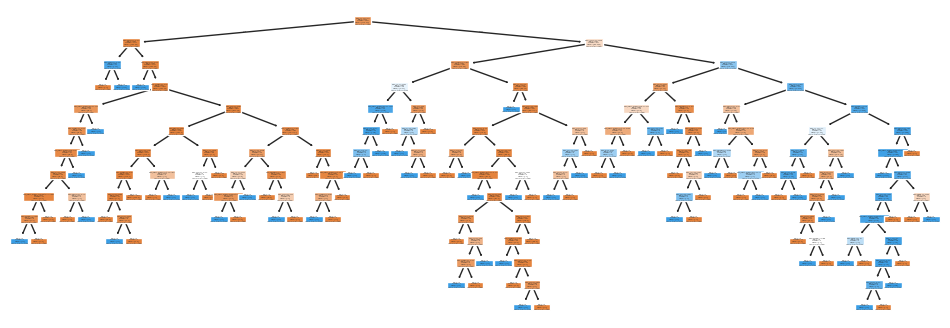

In [107]:
_ = tree.plot_tree(model_RF.estimators_[0],
                   feature_names=feature_names,
                   class_names=['Normal rythm', 'Atrial fibrillation'],
                   filled=True)

## Neighbours Classifiers
### K Neighbours

Model KNeighborsClassifier(n_neighbors=1) n=1 evaluated. 
Accuracy: 0.937007874015748 
F1 Score: 0.7171717171717171 
Precision: 0.7473684210526316 
Recall: 0.6893203883495146 
ROC AUC: 0.8293930186022382
Model KNeighborsClassifier(n_neighbors=2) n=2 evaluated. 
Accuracy: 0.9460067491563554 
F1 Score: 0.7272727272727273 
Precision: 0.8767123287671232 
Recall: 0.6213592233009708 
ROC AUC: 0.8891462239679834
Model KNeighborsClassifier(n_neighbors=3) n=3 evaluated. 
Accuracy: 0.9460067491563554 
F1 Score: 0.7551020408163265 
Precision: 0.7956989247311828 
Recall: 0.7184466019417476 
ROC AUC: 0.9183589021467922
Model KNeighborsClassifier(n_neighbors=4) n=4 evaluated. 
Accuracy: 0.952755905511811 
F1 Score: 0.7692307692307693 
Precision: 0.8860759493670886 
Recall: 0.6796116504854369 
ROC AUC: 0.9382828133106055
Model KNeighborsClassifier() n=5 evaluated. 
Accuracy: 0.9550056242969629 
F1 Score: 0.7938144329896907 
Precision: 0.8461538461538461 
Recall: 0.7475728155339806 
ROC AUC: 0.9472998

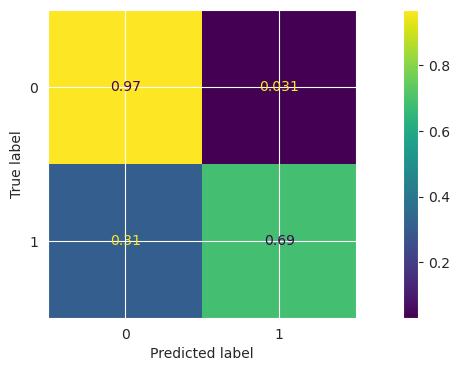

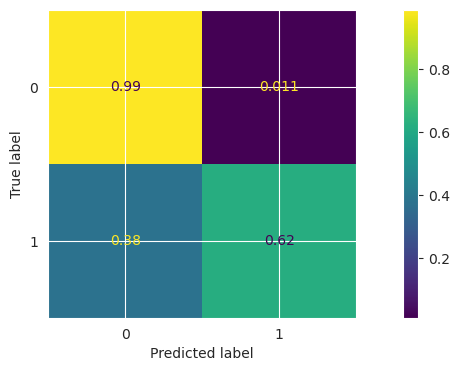

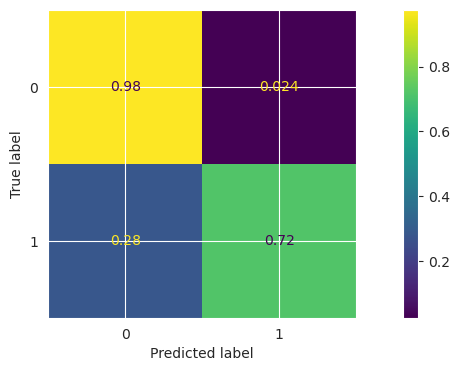

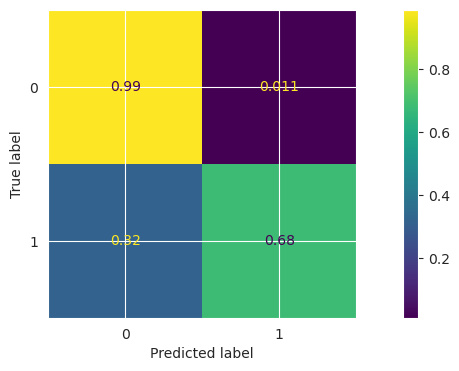

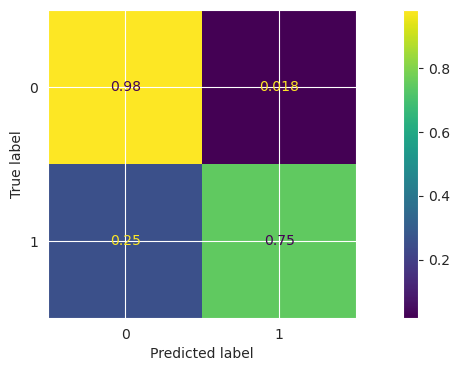

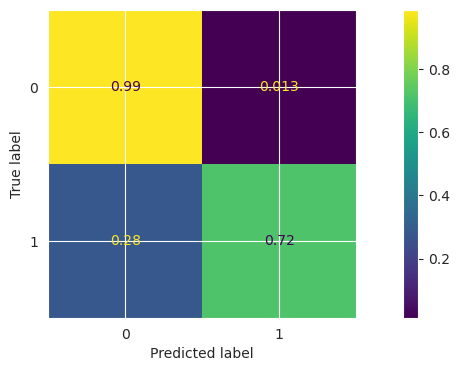

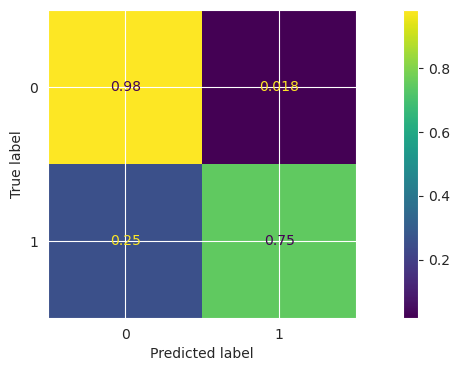

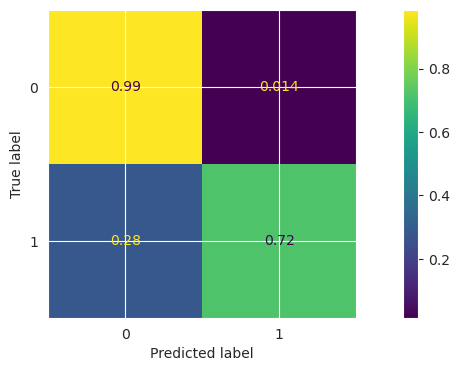

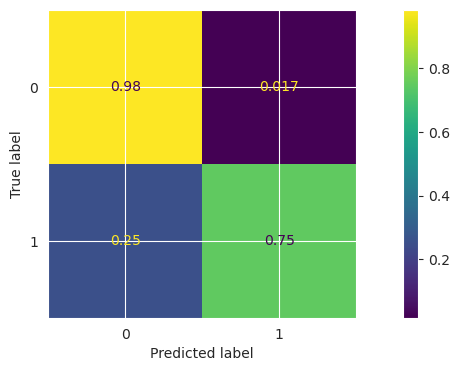

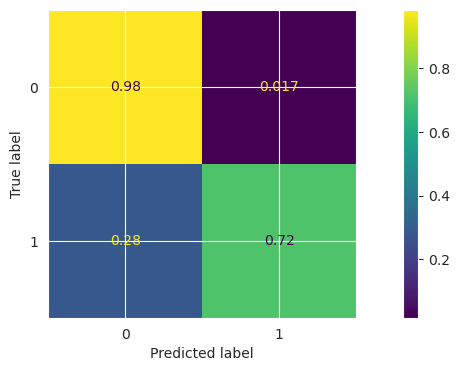

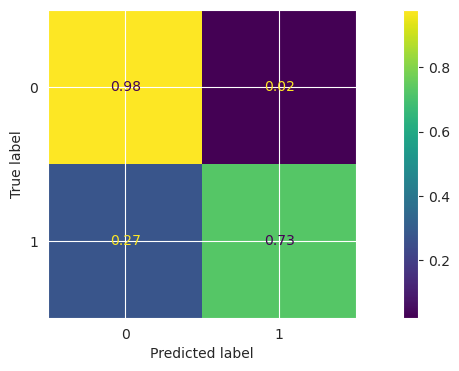

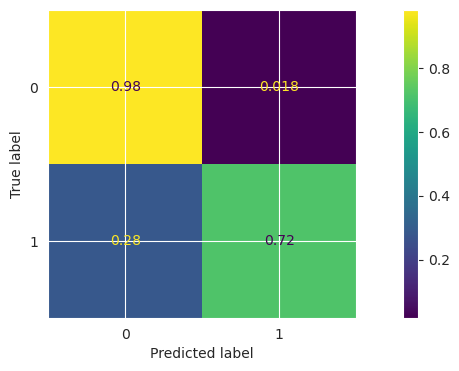

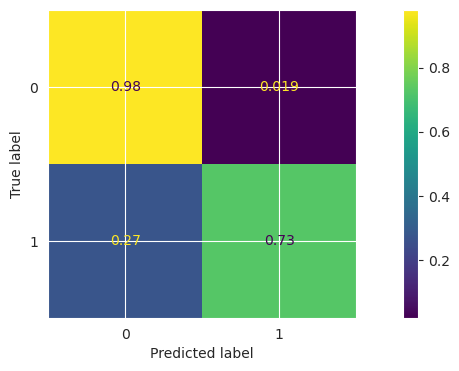

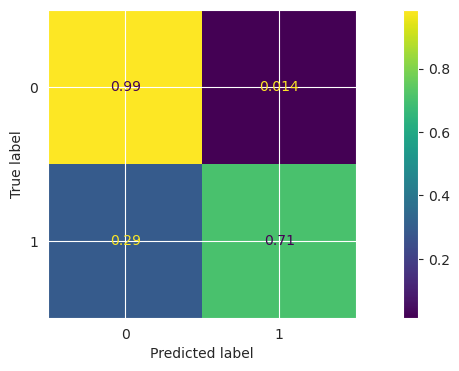

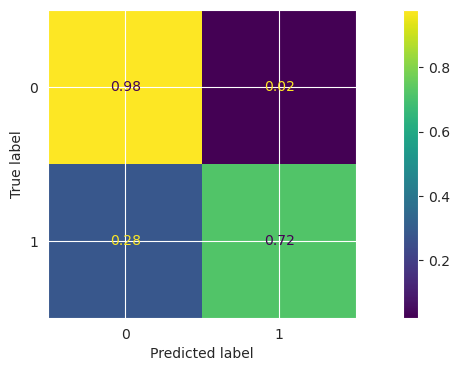

In [108]:
for n in range(15):
    n = n + 1
    model_KNN = KNeighborsClassifier(n_neighbors=n)
    model_KNN.fit(x_train, y_train)

    y_pred_proba = model_KNN.predict_proba(x_test)[:, 1]
    y_pred = model_KNN.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_cur = roc_curve(y_test, y_pred_proba)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_KNN.classes_)
    disp.plot()

    model_KNN_n = str(model_KNN) + str(f" n={n}")
    modelResults(model_KNN_n, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

### Radius Neighbours

Model RadiusNeighborsClassifier(outlier_label='most_frequent', radius=0.5) evaluated. 
Accuracy: 0.8841394825646794 
F1 Score: 0.0 
Precision: 0.0 
Recall: 0.0 
ROC AUC: 0.5
Model RadiusNeighborsClassifier(outlier_label='most_frequent') evaluated. 
Accuracy: 0.8841394825646794 
F1 Score: 0.0 
Precision: 0.0 
Recall: 0.0 
ROC AUC: 0.5
Model RadiusNeighborsClassifier(outlier_label='most_frequent', radius=1.5) evaluated. 
Accuracy: 0.8841394825646794 
F1 Score: 0.0 
Precision: 0.0 
Recall: 0.0 
ROC AUC: 0.5
Model RadiusNeighborsClassifier(outlier_label='most_frequent', radius=2.0) evaluated. 
Accuracy: 0.8841394825646794 
F1 Score: 0.0 
Precision: 0.0 
Recall: 0.0 
ROC AUC: 0.5
Model RadiusNeighborsClassifier(outlier_label='most_frequent', radius=2.5) evaluated. 
Accuracy: 0.8875140607424072 
F1 Score: 0.05660377358490566 
Precision: 1.0 
Recall: 0.02912621359223301 
ROC AUC: 0.5145631067961165
Model RadiusNeighborsClassifier(outlier_label='most_frequent', radius=3.0) evaluated. 
Accuracy

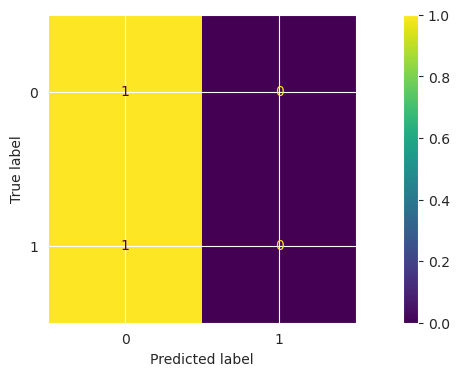

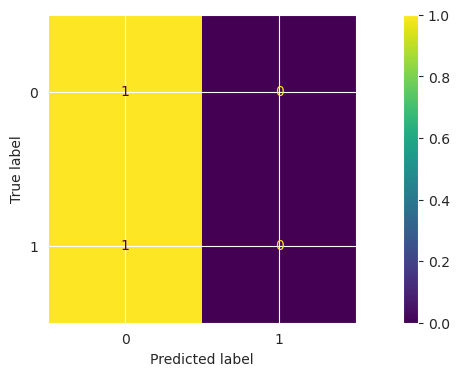

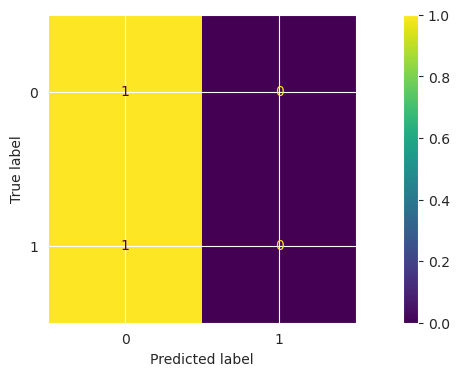

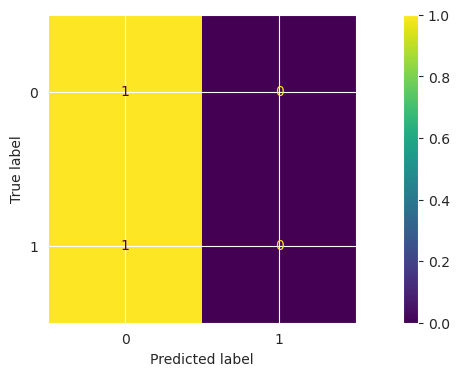

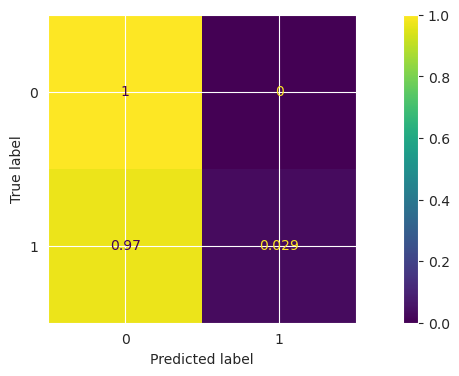

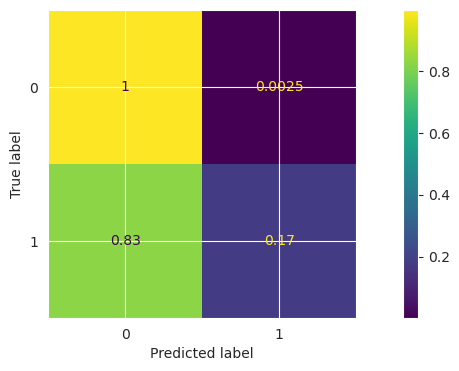

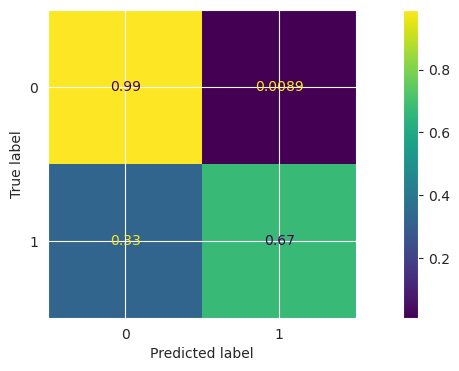

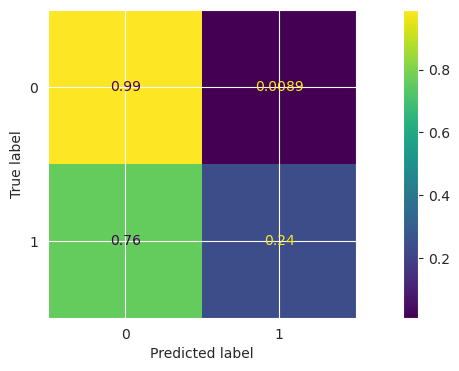

In [109]:
for radius in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0]:
    model_RNC = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    model_RNC.fit(x_train, y_train)

    y_pred_proba = model_RNC.predict_proba(x_test)[:, 1]
    y_pred = model_RNC.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_cur = roc_curve(y_test, y_pred_proba)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_RNC.classes_)
    disp.plot()

    modelResults(model_RNC, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

### Nearest Centroid Classifier

Model NearestCentroid() evaluated. 
Accuracy: 0.8931383577052868 
F1 Score: 0.6666666666666666 
Precision: 0.521978021978022 
Recall: 0.9223300970873787 
ROC AUC: 0.9521665554979124


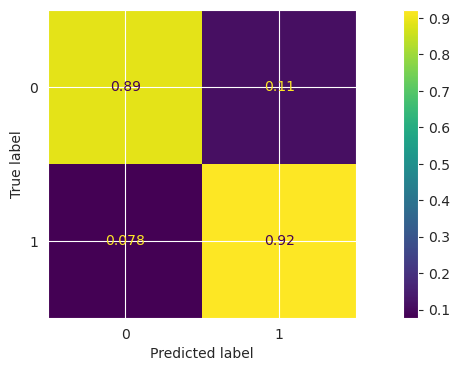

In [110]:
from sklearn.neighbors import NearestCentroid

model_NCC = NearestCentroid()
model_NCC.fit(x_train, y_train)

y_pred_proba = model_NCC.predict_proba(x_test)[:, 1]
y_pred = model_NCC.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_NCC.classes_)
disp.plot()

modelResults(model_NCC, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

In [111]:
##TODO: NCC

## Multi-layer Perceptron Classifier

In [112]:
scaler_mlp = StandardScaler()
x_train_scaled = scaler_mlp.fit_transform(x_train)
x_test_scaled = scaler_mlp.transform(x_test)

In [113]:
##TODO: other solvers? other hidden layer sizes? other max_iter?

Accuracy: 0.954
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       786
           1       0.80      0.81      0.80       103

    accuracy                           0.95       889
   macro avg       0.89      0.89      0.89       889
weighted avg       0.95      0.95      0.95       889



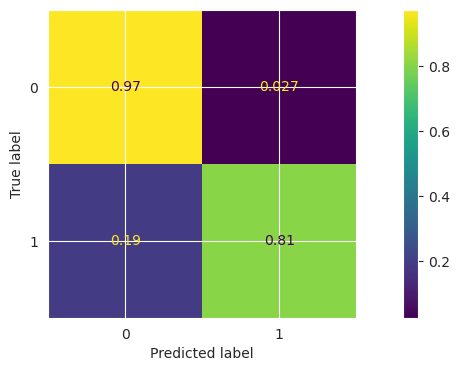

In [114]:
model_MLP = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(100, 50), max_iter=1000, random_state=3003)
model_MLP.fit(x_train_scaled, y_train)

y_pred_proba = model_MLP.predict_proba(x_test_scaled)[:, 1]
y_pred = model_MLP.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_MLP.classes_)
disp.plot()

In [115]:
modelResults(model_MLP, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

Model MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=3003,
              solver='lbfgs') evaluated. 
Accuracy: 0.953880764904387 
F1 Score: 0.8019323671497585 
Precision: 0.7980769230769231 
Recall: 0.8058252427184466 
ROC AUC: 0.9763457595296327


## Gradient Boosting Classifier

Accuracy: 0.956
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       786
           1       0.88      0.72      0.79       103

    accuracy                           0.96       889
   macro avg       0.92      0.85      0.88       889
weighted avg       0.95      0.96      0.95       889



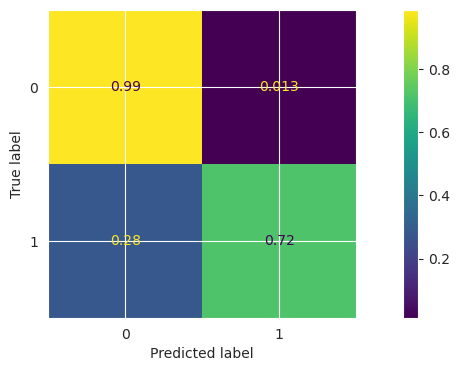

In [116]:
model_GBC = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=3003
)

model_GBC.fit(x_train, y_train)

y_pred_proba = model_GBC.predict_proba(x_test)[:, 1]
y_pred = model_GBC.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_GBC.classes_)
disp.plot()

In [117]:
modelResults(model_GBC, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

Model GradientBoostingClassifier(random_state=3003) evaluated. 
Accuracy: 0.9561304836895388 
F1 Score: 0.7914438502673797 
Precision: 0.8809523809523809 
Recall: 0.7184466019417476 
ROC AUC: 0.9818547889028879


## AdaBoost Classifier

In [118]:
#TODO: implement testing
for n in [50, 100, 200, 300, 400, 500, 1000]:
    clf = AdaBoostClassifier(n_estimators=n)
    scores = cross_val_score(clf, x_train, y_train, cv=5)
    print(scores.mean())

0.9579984411178103


KeyboardInterrupt: 

## Soft voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

voters = [
    ("lr", LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced', random_state=3003)),
    ("rf", RandomForestClassifier(n_estimators=300, max_depth=None, random_state=3003)),
    ("knn", KNeighborsClassifier(n_neighbors=7))
]

soft_vote = VotingClassifier(estimators=voters, voting="soft", n_jobs=-1)
soft_vote.fit(x_train, y_train)

y_pred_proba = soft_vote.predict_proba(x_test)[:, 1]
y_pred = soft_vote.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=soft_vote.classes_)
disp.plot()

modelResults(soft_vote, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)


## Gaussian Processes Classifier

In [ ]:
## TODO: Gaussian Processes Classifier

In [ ]:
# Ensure required imports are available; install if missing
try:
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, WhiteKernel
except Exception:
    !pip install scikit-learn
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, WhiteKernel

In [ ]:
if True:  # Warning, long
    # Define a kernel suitable for scaled features and binary classification
    # Start with signal variance * RBF(length-scale) + small WhiteKernel for numerical stability
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(
        noise_level=1e-3, noise_level_bounds=(1e-6, 1e-1))

    gpc = GaussianProcessClassifier(kernel=kernel, random_state=3003, n_restarts_optimizer=2, max_iter_predict=200)

    gpc.fit(x_train, y_train)

    y_pred = gpc.predict(x_test)
    y_prob = gpc.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_cur = roc_curve(y_test, y_prob)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gpc.classes_)
    disp.plot()

    modelResults(gpc, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

## Gradient-boosted trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, \
    confusion_matrix, classification_report

gbc = GradientBoostingClassifier(random_state=3003)
gbc.fit(x_train, y_train)

y_pred = gbc.predict(x_test)
y_pred_proba = gbc.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_)
disp.plot()

modelResults(gbc, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

gbc_base = GradientBoostingClassifier(random_state=3003)
cv = GridSearchCV(gbc_base, param_grid, scoring="f1", cv=5, n_jobs=-1, refit=True)
cv.fit(x_train, y_train)

best_gbc = cv.best_estimator_
print("Best params:", cv.best_params_)

y_pred = best_gbc.predict(x_test)
y_pred_proba = best_gbc.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbc.classes_)
disp.plot()

modelResults(best_gbc, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)


In [ ]:
## TODO: Gradient-boosted trees

## Semi-supervised learning?

In [ ]:
## TODO: Semi-supervised learning?

# Model evaluation
## Quick conclusion

In [ ]:
original_size = resultsTable.shape[0]
resultsTable = resultsTable.drop_duplicates(subset=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC_AUC'])
print(f"Dropped {resultsTable.shape[0] - original_size} duplicate rows")

In [ ]:
resultsTable

In [ ]:
best_model = resultsTable.loc[resultsTable['F1 Score'].idxmax()]

print(f"The model with the highest F1 score was {best_model['Model']} with an F1 score of {best_model['F1 Score']:.4f}")

## Graphs of numerical metrics
### Logarithmic scale

In [ ]:
#TODO: this is failing out of nowhere and I have no idea how to fix it TwT
if True:
    numeric_metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC_AUC']

    model_labels = [str(model).split('(')[0] for model in resultsTable['Model']]

    fig, axes = plt.subplots(len(numeric_metrics), 1, figsize=(10, len(numeric_metrics) * 8), dpi=100)

    for i, col in enumerate(numeric_metrics):
        bars = axes[i].bar(range(len(resultsTable)), resultsTable[col])
        axes[i].set_xticks(range(len(resultsTable)))
        axes[i].set_xticklabels(model_labels, rotation=45, ha='right')
        axes[i].set_ylabel(col)
        axes[i].set_title(f'{col} by Model')
        axes[i].set_yscale('log')
        axes[i].grid(axis='y', alpha=0.3)

        for j, bar in enumerate(bars):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2., height,
                         f'{resultsTable[col].iloc[j]:.3f}',
                         ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
numeric_metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC_AUC']

model_labels = [str(model).split('(')[0] for model in resultsTable['Model']]

fig, axes = plt.subplots(len(numeric_metrics), 1, figsize=(10, len(numeric_metrics) * 8))

for i, col in enumerate(numeric_metrics):
    bars = axes[i].bar(range(len(resultsTable)), resultsTable[col])
    axes[i].set_xticks(range(len(resultsTable)))
    axes[i].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} by Model')
    axes[i].set_ylim(top=1)
    axes[i].grid(axis='y', alpha=0.3)

    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2., height,
                     f'{resultsTable[col].iloc[j]:.3f}',
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## ROC Curves

In [ ]:
plt.figure(figsize=(20, 20))

for idx, row in resultsTable.iterrows():
    model_name = str(row['Model']).split('(')[0]
    fpr, tpr, thresholds = row['ROC']
    roc_auc = row['ROC_AUC']
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=15)
plt.grid(alpha=1)
plt.tight_layout()
plt.show()